In [0]:
%tensorflow_version 1.x

In [107]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import csv
from collections import Counter, defaultdict
from wordcloud import WordCloud
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
import gensim
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from datetime import datetime

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [108]:
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Analyzing BuzzFeed Real News Content** 

In [109]:
bfreal = pd.read_csv('/content/drive/My Drive/CS221_Project/BuzzFeed_real_news_content.csv')
bfreal.shape

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin..."
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F..."
2,Real_11-Webpage,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com/barack-obama/obama-un...,http://rightwingnews.com/wp-content/uploads/20...,Cassy Fiano,http://rightwingnews.com,{'$date': 1474476044000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/barack-obama/obama-un...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam..."
3,Real_12-Webpage,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co/2de2qs0,http://static.politico.com/e9/11/6144cdc24e319...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,{'$date': 1474974420000},NaN,https://static.politico.com/dims4/default/8a1c...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""He sees it as zero-sum. She b..."
4,Real_13-Webpage,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws/2dh2NFs,http://a.abcnews.com/images/US/AP_Obama_BM_201...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/president-obama...,"{""fb_title"": ""President Obama Vetoes 9/11 Vict..."


In [61]:
bfreal.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin..."
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F..."
2,Real_11-Webpage,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com/barack-obama/obama-un...,http://rightwingnews.com/wp-content/uploads/20...,Cassy Fiano,http://rightwingnews.com,{'$date': 1474476044000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/barack-obama/obama-un...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam..."
3,Real_12-Webpage,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co/2de2qs0,http://static.politico.com/e9/11/6144cdc24e319...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,{'$date': 1474974420000},NaN,https://static.politico.com/dims4/default/8a1c...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""He sees it as zero-sum. She b..."
4,Real_13-Webpage,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws/2dh2NFs,http://a.abcnews.com/images/US/AP_Obama_BM_201...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/president-obama...,"{""fb_title"": ""President Obama Vetoes 9/11 Vict..."


In [62]:
bfreal.describe()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
count,91,91,91,91,91,84,91,56,4,91,90,91
unique,91,91,91,91,87,65,14,53,4,90,90,91
top,Real_30-Webpage,France becomes the first country to ban plasti...,\n\n16505 SHARES SHARES FacebookTwitter Google...,http://eaglerising.com/36966/trump-how-can-we-...,http://static.politico.com/da/f5/44342c424c68b...,"Jack Shafer,Louis Nelson",http://politi.co,{'$date': 1474329600000},https://www.youtube.com/embed/TxBcCSaBtXc?feat...,http://static.politico.com/da/f5/44342c424c68b...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""\u201cWe gotta stand up and b..."
freq,1,1,1,1,3,5,32,2,1,2,1,1


In [63]:
for key,count in bfreal.source.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(bfreal.shape[0]))

http://politi.co:	32
http://cnn.it:	23
http://abcn.ws:	9
http://rightwingnews.com:	7
http://eaglerising.com:	7
http://www.addictinginfo.org:	3
http://addictinginfo.org:	2
http://www.ifyouonlynews.com:	2
http://occupydemocrats.com:	1
http://conservativebyte.com:	1
http://freedomdaily.com:	1
https://www.washingtonpost.com:	1
http://winningdemocrats.com:	1
http://www.opposingviews.com:	1
Total Records:	91


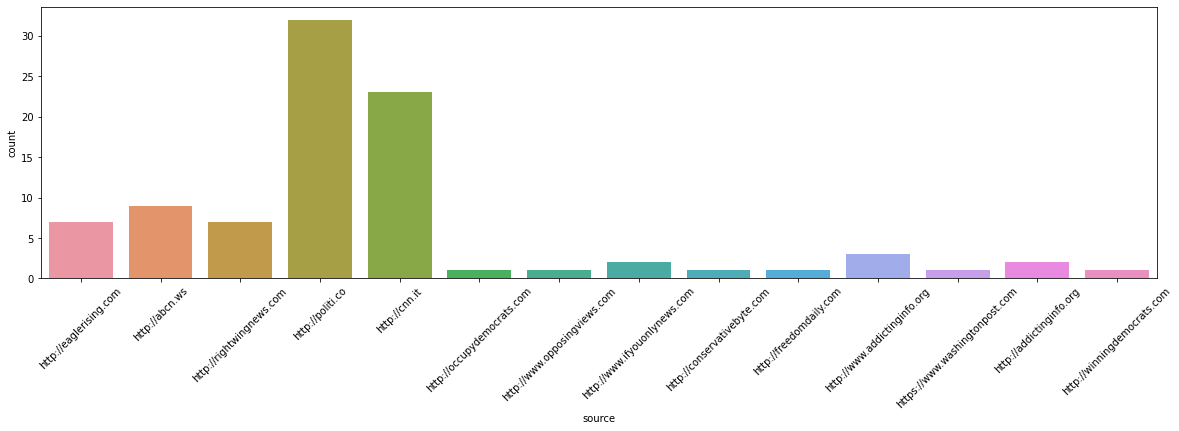

In [64]:
plt.figure(figsize=(20,5))
chart = sns.countplot("source", data=bfreal)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

Adding class indication, and an empty subject column, prior to merging with Fake-and-real-news dataset.

In [65]:
bfreal["class"]=1
bfreal["subject"]=''
bfreal.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,class,subject
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin...",1,
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F...",1,
2,Real_11-Webpage,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com/barack-obama/obama-un...,http://rightwingnews.com/wp-content/uploads/20...,Cassy Fiano,http://rightwingnews.com,{'$date': 1474476044000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/barack-obama/obama-un...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam...",1,
3,Real_12-Webpage,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co/2de2qs0,http://static.politico.com/e9/11/6144cdc24e319...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,{'$date': 1474974420000},NaN,https://static.politico.com/dims4/default/8a1c...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""He sees it as zero-sum. She b...",1,
4,Real_13-Webpage,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws/2dh2NFs,http://a.abcnews.com/images/US/AP_Obama_BM_201...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/president-obama...,"{""fb_title"": ""President Obama Vetoes 9/11 Vict...",1,


Removing all polluting expressions in both text and title

In [0]:
#Seperating Publication info, from actual text
pollution_real = ["⋆ US Herald","– Eagle Rising", "The views expressed in this opinion article are solely those of their author and are not necessarily either shared or endorsed by EagleRising.com", " ⋆ Freedom Daily","Read More", "Authors:"]
for i in pollution_real:
    bfreal['title'] = bfreal['title'].str.replace(i , '')
    bfreal['text'] = bfreal['text'].str.replace(i , '')

### **Analyzing BuzzFeed Fake News Content** 

In [67]:
bffake = pd.read_csv('/content/drive/My Drive/CS221_Project/BuzzFeed_fake_news_content.csv')
bffake.shape

(91, 12)

In [68]:
bffake.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
0,Fake_1-Webpage,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,http://www.addictinginfo.org/2016/09/19/proof-...,http://addictinginfo.addictinginfoent.netdna-c...,Wendy Gittleson,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://addictin...",http://addictinginfo.com/2016/09/19/proof-the-...,"{""publisher"": ""Addicting Info | The Knowledge ..."
1,Fake_10-Webpage,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,http://eaglerising.com/36899/charity-clinton-f...,http://eaglerising.com/wp-content/uploads/2016...,View All Posts,http://eaglerising.com,{'$date': 1474416521000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36899/charity-clinton-f...,"{""description"": ""The possibility that CHAI dis..."
2,Fake_11-Webpage,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,http://eaglerising.com/36880/a-hillary-clinton...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Tony Elliott",http://eaglerising.com,{'$date': 1474416638000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36880/a-hillary-clinton...,"{""description"": ""Hillary Clinton may be the fi..."
3,Fake_12-Webpage,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",http://www.addictinginfo.org/2016/09/19/trumps...,http://addictinginfo.addictinginfoent.netdna-c...,John Prager,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://2.gravat...",http://addictinginfo.com/2016/09/19/trumps-lat...,"{""publisher"": ""Addicting Info | The Knowledge ..."
4,Fake_13-Webpage,Website is Down For Maintenance,Website is Down For Maintenance,http://www.proudcons.com/clinton-foundation-ca...,NaN,NaN,http://www.proudcons.com,NaN,NaN,NaN,NaN,"{""og"": {""url"": ""http://www.proudcons.com"", ""ty..."


In [69]:
bffake.describe()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
count,91,91,91,83,81,57,83,77,21,81,80,91
unique,91,87,87,80,79,30,22,69,21,79,78,81
top,Fake_4-Webpage,Clinton Foundation Spent 5.7% on Charity; Rest...,Back when the news first broke about the pay-t...,http://eaglerising.com/36880/a-hillary-clinton...,http://eaglerising.com/wp-content/uploads/2016...,Terresa Monroe-hamilton,http://rightwingnews.com,{'$date': 1474588800000},https://www.youtube.com/embed/7Mv4r2Vw6zU?feat...,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36880/a-hillary-clinton...,{}
freq,1,2,2,2,2,6,17,4,1,2,2,8


In [70]:
for key,count in bffake.source.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(bffake.shape[0]))

http://rightwingnews.com:	17
http://freedomdaily.com:	16
http://eaglerising.com:	11
http://occupydemocrats.com:	6
https://goo.gl:	3
http://www.addictinginfo.org:	3
http://www.thepoliticalinsider.com:	3
http://www.proudcons.com:	2
http://clashdaily.com:	2
https://ihavethetruth.com:	2
http://theblacksphere.net:	2
http://winningdemocrats.com:	2
http://conservativetribune.com:	2
http://usherald.com:	2
http://100percentfedup.com:	2
http://allenwestrepublic.com:	2
http://addictinginfo.org:	1
http://author.groopspeak.com:	1
http://www.yesimright.com:	1
http://author.addictinginfo.org:	1
http://conservativebyte.com:	1
http://www.chicksontheright.com:	1
Total Records:	91


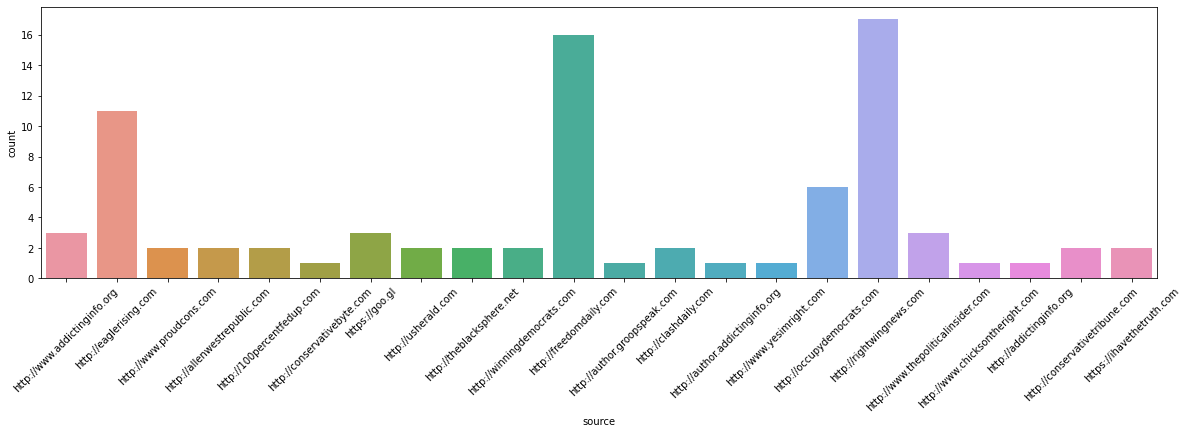

In [71]:
plt.figure(figsize=(20,5))
chart = sns.countplot("source", data=bffake)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [72]:
bffake["class"]=0
bffake["subject"]=''
bffake.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,class,subject
0,Fake_1-Webpage,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,http://www.addictinginfo.org/2016/09/19/proof-...,http://addictinginfo.addictinginfoent.netdna-c...,Wendy Gittleson,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://addictin...",http://addictinginfo.com/2016/09/19/proof-the-...,"{""publisher"": ""Addicting Info | The Knowledge ...",0,
1,Fake_10-Webpage,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,http://eaglerising.com/36899/charity-clinton-f...,http://eaglerising.com/wp-content/uploads/2016...,View All Posts,http://eaglerising.com,{'$date': 1474416521000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36899/charity-clinton-f...,"{""description"": ""The possibility that CHAI dis...",0,
2,Fake_11-Webpage,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,http://eaglerising.com/36880/a-hillary-clinton...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Tony Elliott",http://eaglerising.com,{'$date': 1474416638000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36880/a-hillary-clinton...,"{""description"": ""Hillary Clinton may be the fi...",0,
3,Fake_12-Webpage,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",http://www.addictinginfo.org/2016/09/19/trumps...,http://addictinginfo.addictinginfoent.netdna-c...,John Prager,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://2.gravat...",http://addictinginfo.com/2016/09/19/trumps-lat...,"{""publisher"": ""Addicting Info | The Knowledge ...",0,
4,Fake_13-Webpage,Website is Down For Maintenance,Website is Down For Maintenance,http://www.proudcons.com/clinton-foundation-ca...,NaN,NaN,http://www.proudcons.com,NaN,NaN,NaN,NaN,"{""og"": {""url"": ""http://www.proudcons.com"", ""ty...",0,


Removing all polluting expressions in both text and title

In [0]:
pollution_fake = ["⋆ US Herald","– Eagle Rising", "The views expressed in this opinion article are solely those of their author and are not necessarily either shared or endorsed by EagleRising.com", " ⋆ Freedom Daily","Read More", "Authors:"]
for i in pollution_fake:
    bffake['title'] = bffake['title'].str.replace(i , '')
    bffake['text'] = bffake['text'].str.replace(i , '')

### **Analyzing Fake-and-real-news Real News Content** 

In [74]:
reald = pd.read_csv('/content/drive/My Drive/CS221_Project/True.csv')
reald.shape

(21417, 4)

In [75]:
reald.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [76]:
for key,count in reald.subject.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(reald.shape[0]))

politicsNews:	11272
worldnews:	10145
Total Records:	21417


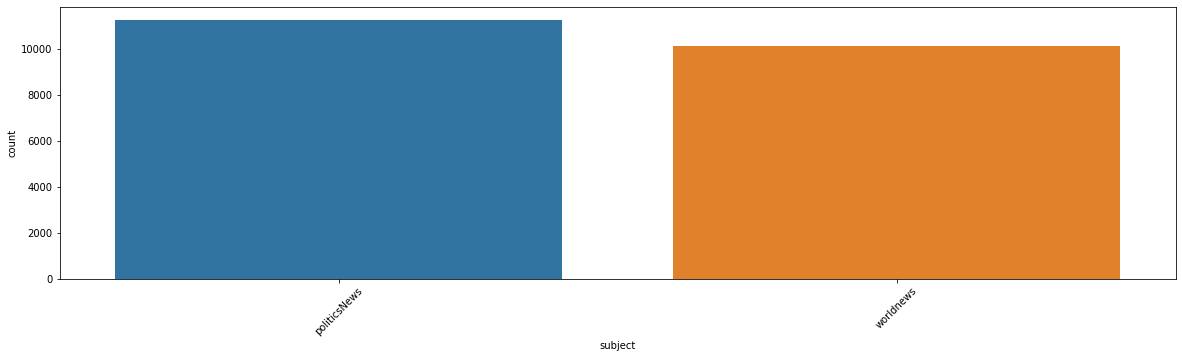

In [77]:
plt.figure(figsize=(20,5))
chart = sns.countplot("subject", data=reald)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [78]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(reald.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of publication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)
#Thus we have list of indices where publisher is not mentioned
#lets check
reald.iloc[unknown_publishers].text

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [79]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for idx,row in enumerate(reald.text.values):
    if idx in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

#Replace existing text column with new text
#add seperate column for publication info in case we want to use it later
reald["source"] = publisher
reald["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers
reald.head()

,title,text,subject,date,source
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [80]:
#checking for rows with empty text
[index for index,text in enumerate(reald.text.values) if str(text).strip() == '']

[8970]

In [0]:
#dropping this record
reald = reald.drop(8970, axis=0)

In [82]:
#renaming date column before merging with FakenewsNet dataset, and adding a class column
reald["class"]=1
reald = reald.rename(columns={"date":"publish_date"})
reald.head()

,title,text,subject,publish_date,source,class
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters),1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters),1


### **Analyzing Fake-and-real-news Fake News Content** 

In [83]:
faked = pd.read_csv('/content/drive/My Drive/CS221_Project/Fake.csv')
faked.shape

(23481, 4)

In [84]:
faked.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [85]:
for key,count in faked.subject.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(faked.shape[0]))

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


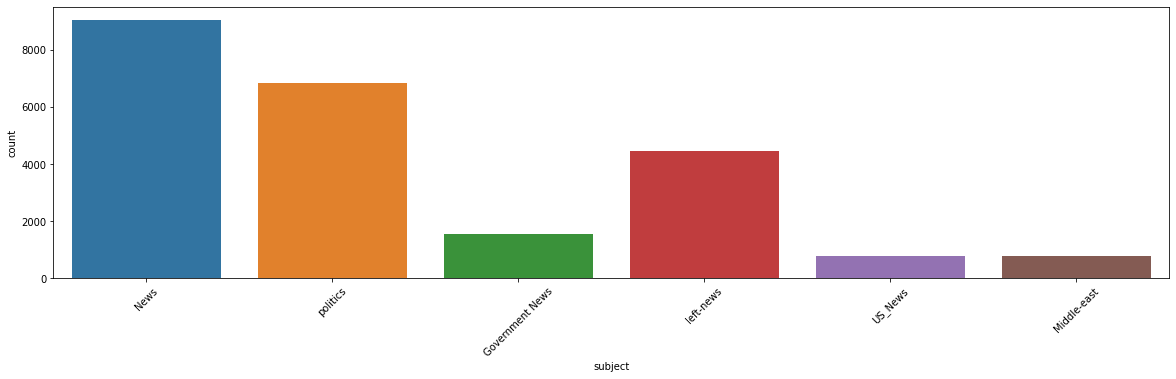

In [86]:
plt.figure(figsize=(20,5))
chart = sns.countplot("subject", data=faked)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [87]:
#checking for rows with empty text
empty_faked_index = [index for index,text in enumerate(faked.text.values) if str(text).strip() == '']
print("No of empty rows: {}".format(len(empty_faked_index)))
faked.iloc[empty_faked_index].tail()

No of empty rows: 630


,title,text,subject,date
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"


In [88]:
#dropping this record
for i in empty_faked_index:
  faked = faked.drop(i, axis=0)

faked.shape

(22851, 4)

Removing polluting expressions in both title and text columns

In [0]:
pollution_faked = ["(VIDEO)", "Photo by", "/Getty Images", "Featured image", "pic.twitter.com"]
for i in pollution_faked:
    faked['title'] = faked['title'].str.replace(i , '')
    faked['text'] = faked['text'].str.replace(i , '')

In [90]:
#renaming date column before merging with FakenewsNet dataset, adding a class column and a source one set to "Unknown"
faked["class"]=0
faked["source"]="Unknown"
faked = faked.rename(columns={"date":"publish_date"})
faked.head()

,title,text,subject,publish_date,class,source
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,Unknown
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,Unknown
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,Unknown
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,Unknown
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,Unknown


### **Merging all 4 datasets into one** 

**Baseline**: merge title and text, and keep only the resulting value along with the class

In [91]:
bfreal_short = bfreal[["title", "text","class"]]
bfreal_short.head()

,title,text,class
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,1
2,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",1
3,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,1
4,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,1


In [92]:
bffake_short = bffake[["title", "text","class"]]
bffake_short.head()

,title,text,class
0,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,0
1,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,0
2,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,0
3,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",0
4,Website is Down For Maintenance,Website is Down For Maintenance,0


In [93]:
reald_short = reald[["title", "text","class"]]
reald_short.head()

,title,text,class
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,1


In [94]:
faked_short = faked[["title", "text","class"]]
faked_short.tail()

,title,text,class
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,0
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,0


In [95]:
dataset = bfreal_short.append([bffake_short, reald_short, faked_short], ignore_index=True)
dataset.shape

(44449, 3)

In [96]:
#Combining Title and Text
dataset["text"] = dataset["title"] + " " + dataset["text"]
dataset = dataset.drop(["title"], axis=1)
dataset.head()

,text,class
0,Another Terrorist Attack in NYC…Why Are we STI...,1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",1
2,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...",1
3,Trump vs. Clinton: A Fundamental Clash over Ho...,1
4,"President Obama Vetoes 9/11 Victims Bill, Sett...",1


In [97]:
dataset.tail()

,text,class
44444,McPain: John McCain Furious That Iran Treated ...,0
44445,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,0
44446,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,0
44447,How to Blow $700 Million: Al Jazeera America F...,0
44448,10 U.S. Navy Sailors Held by Iranian Military ...,0


In [98]:
dataset.count()

text     44449
class    44449
dtype: int64

In [99]:
dataset["class"].value_counts()

0    22942
1    21507
Name: class, dtype: int64

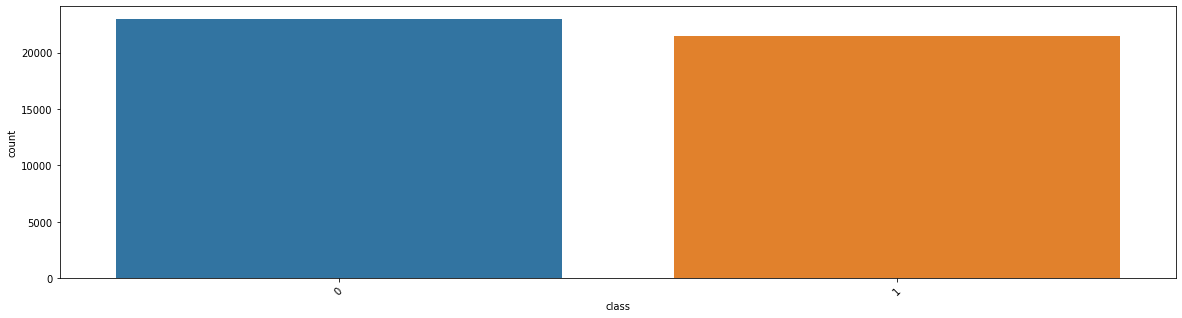

In [100]:
plt.figure(figsize=(20,5))
chart = sns.countplot("class", data=dataset)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

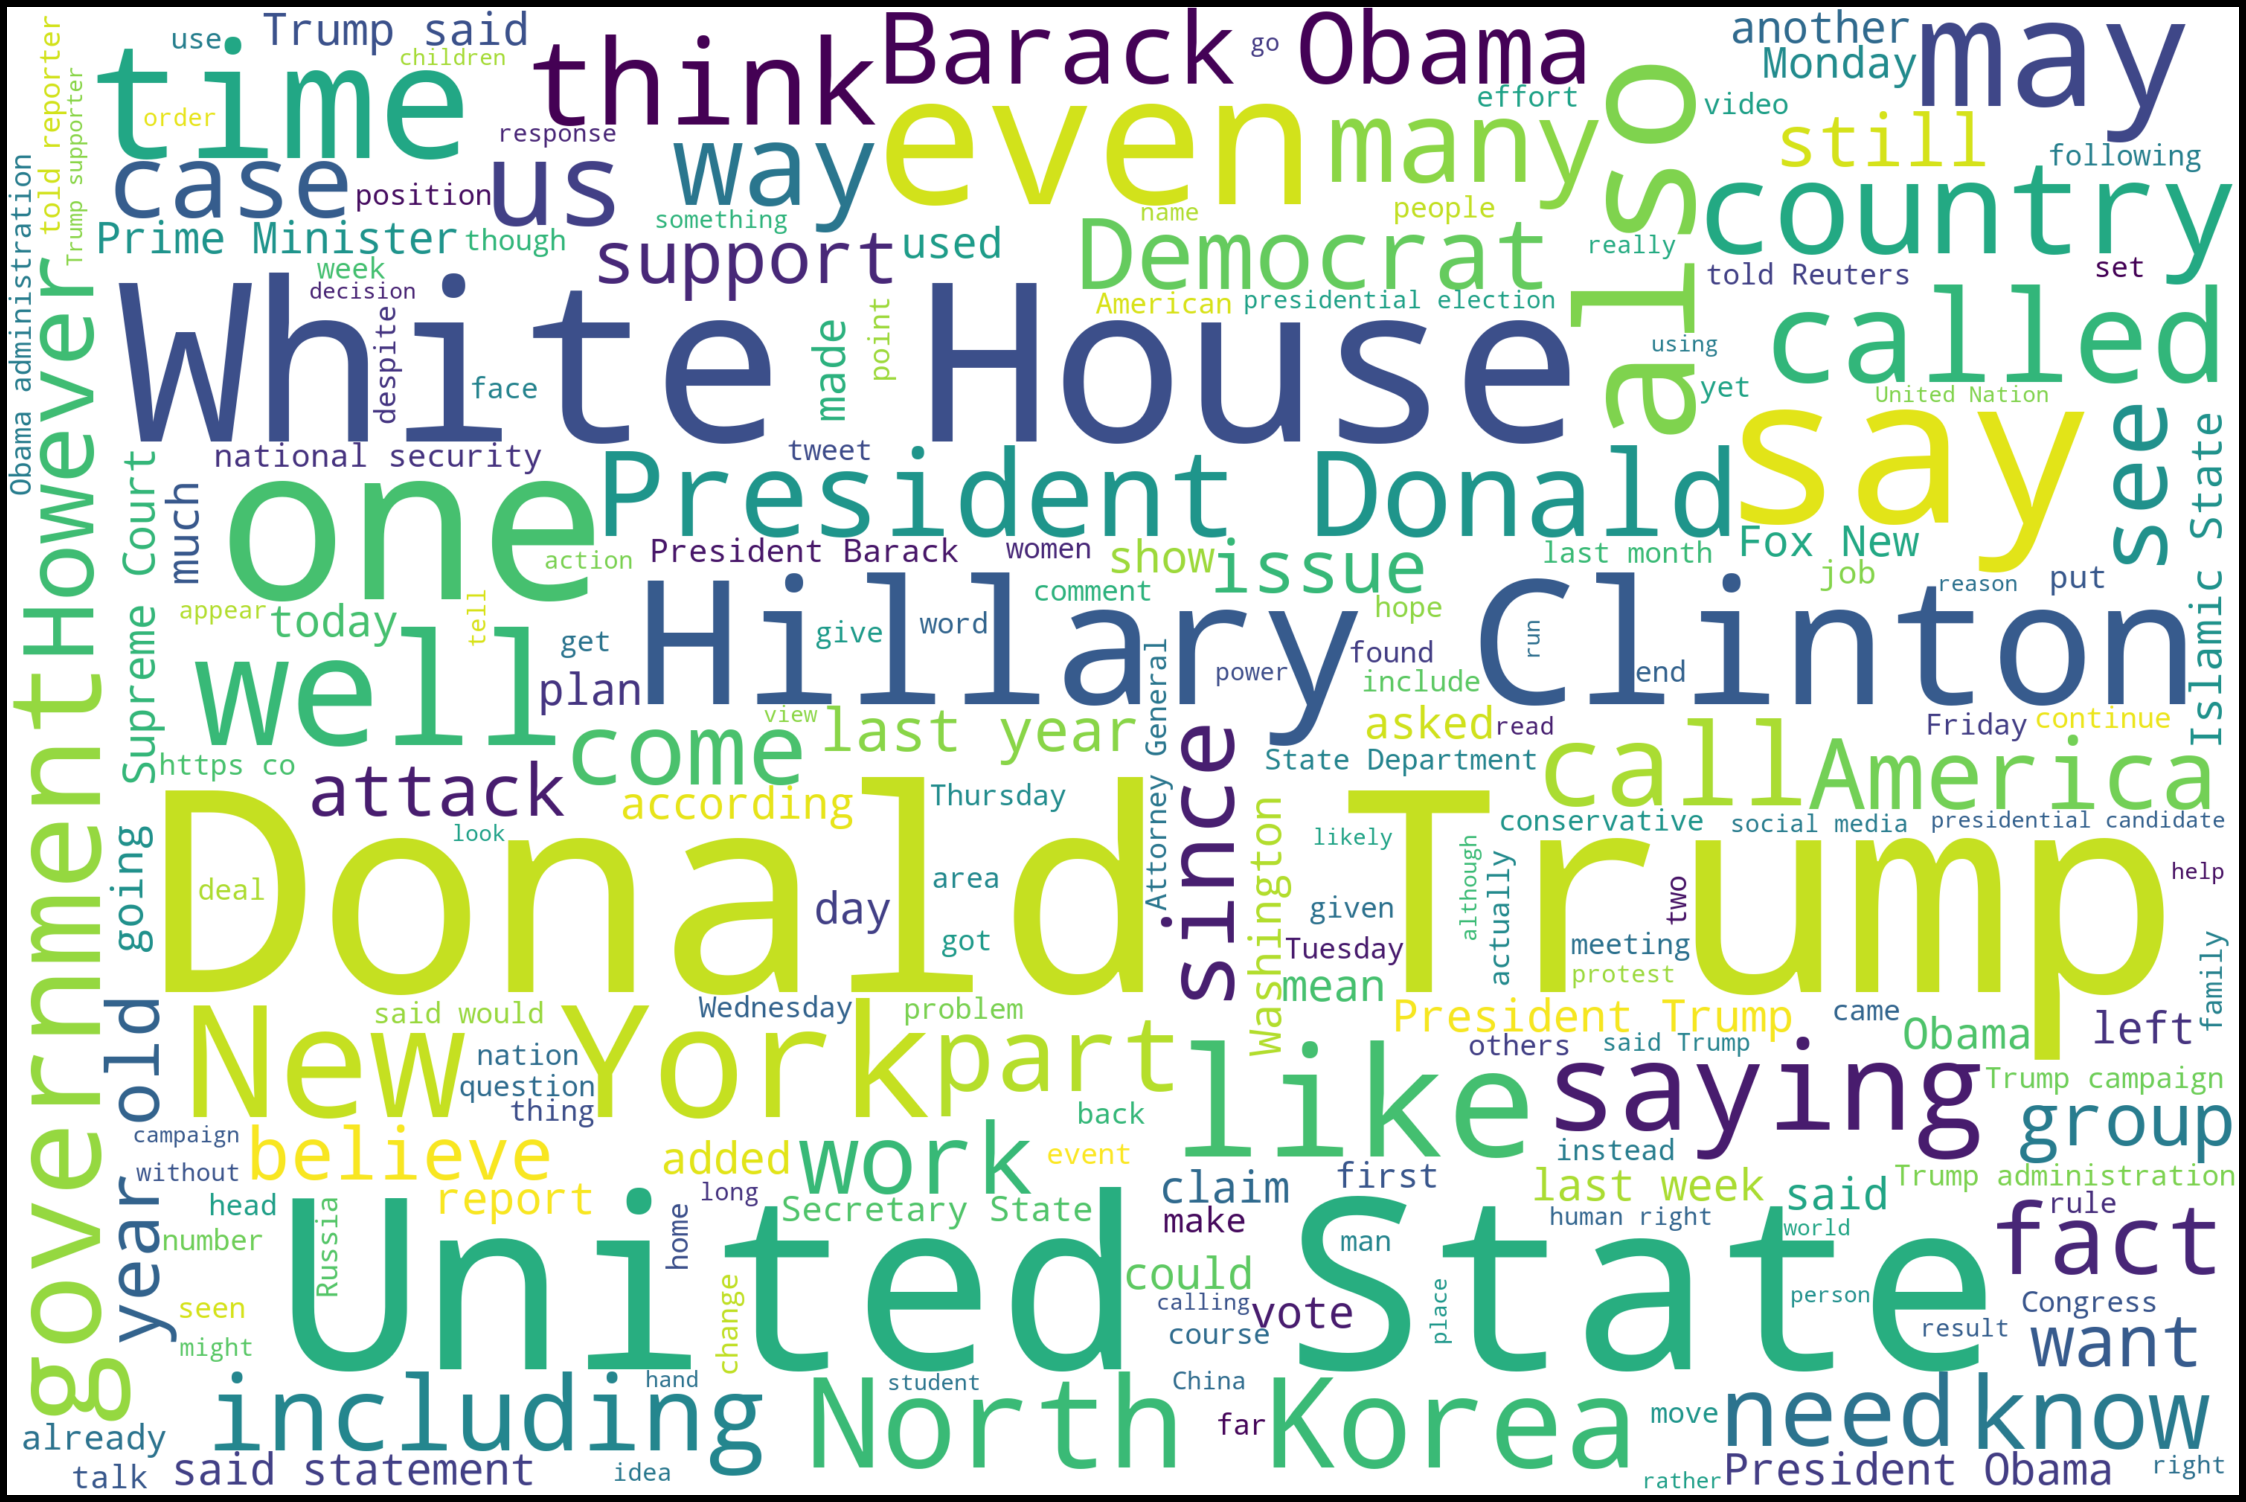

In [101]:
#Word Cloud
text = ''
for news in dataset.text.values:
    text += news
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()
del text

**Alternative**: keep 5 columns? leverage subject on top of title+text?

## **Generating Oracle**

In [0]:
num_samples = 25
sampled = dataset.sample(n=num_samples)
sampled['text'].to_csv('/content/drive/My Drive/CS221_Project/oracle_data.csv', index=False)

After we've generated the file, we'd fill it out and then
run the following:

In [110]:
num_samples = 25
sampled = pd.read_csv('/content/drive/My Drive/CS221_Project/oracle_answers.csv')
guesses = pd.read_csv('/content/drive/My Drive/CS221_Project/oracle_data_filled_lowercase.csv')
guesses['roland'] = pd.to_numeric(guesses['roland'])
guesses['sathya'] = pd.to_numeric(guesses['sathya'])
accuracy = pd.DataFrame()
accuracy['roland'] = (sampled['class']==guesses['roland'])
accuracy['sathya'] = (sampled['class']==guesses['sathya'])
accuracy['max'] = (accuracy['sathya'] | accuracy['roland']) #picking the right answer if one of us chose it
accuracy['min'] = (accuracy['sathya'] & accuracy['roland']) #picking the wrong answer if one of us chose it
print("Roland accuracy: ", sum(accuracy['roland'])/num_samples)
print("Sathya accuracy: ", sum(accuracy['sathya'])/num_samples)
print("Maximum accuracy: ", sum(accuracy['max'])/num_samples)
print("Minimum accuracy: ", sum(accuracy['min'])/num_samples)


Roland accuracy:  0.84
Sathya accuracy:  0.84
Maximum accuracy:  0.88
Minimum accuracy:  0.8


## **Tokenization, analyze of text structure, word occurence and repetition**

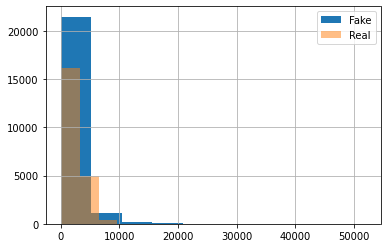

In [105]:
dataset_real = dataset.loc[dataset['class'] == 1]
dataset_fake = dataset.loc[dataset['class'] == 0]
dataset_fake['text'].str.len().hist()
dataset_real['text'].str.len().hist(alpha=0.5)
plt.legend(['Fake', 'Real'])

Some fake news had lots of upper case, which may generate a strong bias in detection since they can be easily used in real news as well. 
So tokenizing sentences, passing all text to lower case, removing stop words, punctuation and single-character words

In [120]:
print(dataset.columns)

Index(['text', 'class'], dtype='object')


In [0]:
y = []
y = dataset["class"].values
#Converting X to format acceptable by gensim, removing stopwords and punctuation in the process
stop_words = set(nltk.corpus.stopwords.words("english"))
X = []
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in dataset["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

#del dataset

In [0]:
#put X back together and save as a CSV for input into BERT.
bert_dataset = []
for entry in X:
  bert_dataset.append(' '.join(entry))
bert_dataset = np.asarray(bert_dataset) 
bert_dataset = pd.DataFrame(data=bert_dataset, columns=["text"])
bert_dataset['class'] = dataset['class']

In [0]:
bert_dataset.to_csv('/content/drive/My Drive/CS221_Project/dataset_reference.csv', index=False)

In [0]:
X[0][:10]

['another',
 'terrorist',
 'attack',
 'nyc',
 'still',
 'politically',
 'correct',
 'saturday',
 'september',
 '17']

In [0]:
len(X)

44449

In [0]:
#Identifying indexes of real and fake news
real_idx = [i for i,v in enumerate(y) if v == 1]
fake_idx = [i for i,v in enumerate(y) if v == 0]
print(len(real_idx), len(fake_idx))

21507 22942


In [0]:
X_real = []
X_fake = []
X_real = [X[i] for i in real_idx]
X_fake = [X[j] for j in fake_idx]
print(len(X_real), len(X_fake))

21507 22942


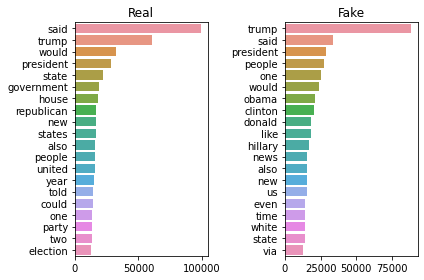

In [0]:
#Let's analyze most frequent words
corpus_real=[word for i in X_real for word in i]
counter_real=Counter(corpus_real)
most_real=counter_real.most_common()

x1, x2= [], []
for word,count in most_real[:40]:
    if (word not in stop_words and len(word) > 1):
        x1.append(word)
        x2.append(count)
 
corpus_fake=[word for j in X_fake for word in j]
counter_fake=Counter(corpus_fake)
most_fake=counter_fake.most_common()

x3, x4= [], []
for word,count in most_fake[:40]:
    if (word not in stop_words and len(word) > 1):
        x3.append(word)
        x4.append(count)

fig,(ax1, ax2) = plt.subplots(1,2)
sns.barplot(x=x2[:20],y=x1[:20],ax=ax1).set_title('Real')
sns.barplot(x=x4[:20],y=x3[:20],ax=ax2).set_title('Fake')
fig.tight_layout()

 bigrams and trigrams in both classes

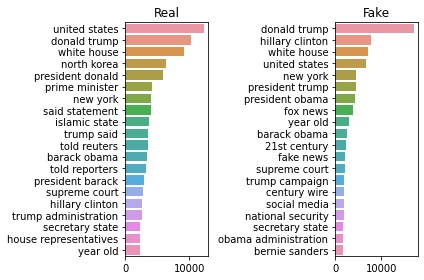

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(stop_words='english', lowercase=True, ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

top_n_bigrams_real=get_top_ngram(dataset_real['text'],2)[:20]
x_,y_=map(list,zip(*top_n_bigrams_real))
top_n_bigrams_fake=get_top_ngram(dataset_fake['text'],2)[:20]
w_,z_=map(list,zip(*top_n_bigrams_fake))

fig,(ax1, ax2) = plt.subplots(1,2)
sns.barplot(x=y_,y=x_,ax=ax1).set_title('Real')
sns.barplot(x=z_,y=w_,ax=ax2).set_title('Fake')
fig.tight_layout()

TF-IDF, k-means (to be continued)

In [0]:
#Alternative method of analyzing ngrams via TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
class NewTfidfVectorizer(TfidfVectorizer):
    def _word_ngrams(self, tokens, stop_words=None):

        # First get tokens without stop words
        tokens = super(TfidfVectorizer, self)._word_ngrams(tokens, None)
        if stop_words is not None:
            new_tokens=[]
            for token in tokens:
                split_words = token.split(' ')

                # Only check the first and last word for stop words
                if split_words[0] not in stop_words and split_words[-1] not in stop_words:
                    new_tokens.append(token)
            return new_tokens

        return tokens

vectorizer = NewTfidfVectorizer(stop_words='english', ngram_range=(3,3))
vectorizer.fit(dataset["text"])

NewTfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0,
                   max_features=None, min_df=1, ngram_range=(3, 3), norm='l2',
                   preprocessor=None, smooth_idf=True, stop_words='english',
                   strip_accents=None, sublinear_tf=False,
                   token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
                   use_idf=True, vocabulary=None)

In [0]:
#K-means
#we can also pursue dimensionality reduction using LSA (I can write this code) if we want to improve further.
X_vec = vectorizer.fit_transform(dataset['text'])
labels = dataset['class']
true_k = np.unique(labels).shape[0]

km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,init_size=1000, 
                     batch_size=1000, verbose=False)
print("Clustering sparse data with %s" % km)
km.fit(X_vec)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_vec, km.labels_, sample_size=1000))

print()

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=2, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=False)
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand-Index: 0.000
Silhouette Coefficient: 0.000



Topic Modeling exploration with pyLDAvis

In [0]:
#Tokenization and lemmatization
from nltk.stem import PorterStemmer, WordNetLemmatizer

def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['text']:
        words=[w for w in nltk.word_tokenize(news) if (w not in stop_words)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus=preprocess_news(dataset)

In [0]:
#Let’s create the bag of words model using gensim
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [0]:
#And finally create the LDA model
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.009*"The" + 0.006*"said" + 0.005*"police" + 0.004*"people" + 0.004*"one" + 0.003*"law" + 0.003*"group" + 0.003*"year" + 0.003*"also" + 0.002*"case"'),
 (1,
  '0.017*"said" + 0.011*"The" + 0.006*"U.S." + 0.006*"government" + 0.005*"country" + 0.005*"United" + 0.005*"would" + 0.004*"military" + 0.004*"Syria" + 0.004*"States"'),
 (2,
  '0.012*"said" + 0.012*"Trump" + 0.011*"The" + 0.007*"U.S." + 0.007*"would" + 0.006*"House" + 0.005*"Obama" + 0.005*"Clinton" + 0.004*"President" + 0.004*"state"'),
 (3,
  '0.022*"Trump" + 0.006*"The" + 0.005*"Clinton" + 0.005*"people" + 0.005*"Hillary" + 0.005*"Donald" + 0.005*"like" + 0.004*"one" + 0.004*"Obama" + 0.004*"said"')]

In [0]:
%%capture
!pip install pyLDAvis

In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.137360 -0.048712       1        1  30.342966
2     -0.056781 -0.114434       2        1  28.219912
1     -0.159701  0.053241       3        1  22.938581
0      0.079123  0.109905       4        1  18.498539, topic_info=         Term           Freq          Total Category  logprob  loglift
72      Trump  113141.000000  113141.000000  Default  30.0000  30.0000
1135     U.S.   38930.000000   38930.000000  Default  29.0000  29.0000
257      said  106179.000000  106179.000000  Default  28.0000  28.0000
26    Clinton   31515.000000   31515.000000  Default  27.0000  27.0000
1119    House   22993.000000   22993.000000  Default  26.0000  26.0000
...       ...            ...            ...      ...      ...      ...
258       say    4159.258789   26973.460938   Topic4  -6.1975  -0.1820
1233    state    4065.829834   25062.636719   Topic4  -6.2202  -0.1313
2137     told    3957.359131   21287.869141   Topic4  -6.2473   0.0049
556     would    4024.636719   50896.585938   Topic4  -6.2304  -0.8499
501    public    3432.295898   11269.496094   Topic4  -6.3896   0.4986

[403 rows x 6 columns], token_table=        Topic      Freq   Term
term                          
10657       4  0.998114    911
12604       4  0.996796   ACLU
242268      1  0.997707    ACR
242268      4  0.001771    ACR
1112        1  0.031616    Act
...       ...       ...    ...
556         4  0.079082  would
313         1  0.180479   year
313         2  0.354485   year
313         3  0.290513   year
313         4  0.174509   year

[856 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

## **Vectorization via Word2Vec**

In [0]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [0]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each of 122681 words by a 100dim vector.

122607

In [0]:
#see a sample vector for random word 
w2v_model["trump"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-0.23841709,  1.3354108 , -0.6919239 , -0.12343608, -1.4060798 ,
       -0.76426494,  2.3492906 , -1.9849272 , -0.03576379, -0.00844065,
        0.07340823, -1.3235728 , -1.2768582 ,  0.35895804,  1.1463741 ,
       -0.5668165 , -1.8954624 ,  2.1769698 ,  1.0292587 ,  0.21681176,
        1.6227388 ,  0.8090576 , -0.63486314, -2.1795082 , -1.3369257 ,
       -1.6671324 ,  3.3228323 , -1.2399857 , -1.9666839 , -0.4429984 ,
        2.0725534 ,  2.6585581 ,  1.8953489 ,  0.39626318,  0.61162806,
       -1.8718843 ,  0.34066308,  2.088411  ,  2.5624542 ,  0.4486007 ,
       -1.6112367 , -0.01345957,  1.038689  ,  0.6222583 ,  0.5324806 ,
        2.1952116 ,  0.47175866, -0.3296178 , -1.766407  , -2.9407232 ,
       -0.70016044, -1.0507855 , -1.185457  ,  1.1941137 ,  1.6779472 ,
        0.5532164 ,  2.3650205 , -0.4146695 ,  1.2624074 ,  0.2491945 ,
        0.6272961 , -0.97934145,  0.665432  ,  0.9622943 ,  1.7841017 ,
        0.05670587, -2.7333672 ,  0.8134905 , -1.739738  , -1.34

In [0]:
w2v_model.wv.most_similar("freedom")

[('freedoms', 0.6846910715103149),
 ('liberty', 0.6075497269630432),
 ('nonobjective', 0.5719642639160156),
 ('free', 0.5694098472595215),
 ('expression', 0.547289252281189),
 ('democracy', 0.5379995107650757),
 ('navigation', 0.5124461650848389),
 ('sovereignty', 0.49387726187705994),
 ('principles', 0.48570337891578674),
 ('infringes', 0.4854969084262848)]

In [0]:
w2v_model.wv.most_similar("people")

[('folks', 0.6976144313812256),
 ('americans', 0.6708126068115234),
 ('citizens', 0.6527140140533447),
 ('blacks', 0.599380373954773),
 ('adults', 0.5909599661827087),
 ('individuals', 0.5823972225189209),
 ('others', 0.5768717527389526),
 ('men', 0.5748890042304993),
 ('person', 0.5723284482955933),
 ('voters', 0.5709743499755859)]

In [0]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of original word to number is preserved in word_index property of tokenizer

#Tokenizer applies basic processing like changing it to lower case, explicitely setting that as True

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [0]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[105, 638, 165, 3908, 102, 1678, 1867, 409, 524, 890]

In [0]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print("{} -> {}".format(word, num))
    if num == 10:
        break        

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


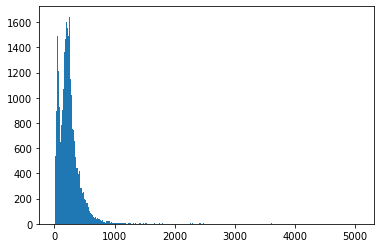

In [0]:
# Making histogram for no of words in news shows that most news article are under 700 words.
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [0]:
# Most of the news have less than 700 characters
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])

43524

In [0]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700 

#Making all news of size maxlen defined above, padding with 0 when needed
X = pad_sequences(X, maxlen=maxlen)

In [0]:
#Checking
len(X[0])

700

In [0]:
#Saving this tokenized and vectorized version to file
with open('/content/drive/My Drive/CS221_Project/X_w2v_tok.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(X)

## **Modelization** 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 
print(len(X_train), len(X_test))

33336 11113


# Naïve Bayes model

In [0]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_model = MultinomialNB().fit(X_train,y_train)

In [0]:
#Model Evaluation
predictions = naive_bayes_model.predict(X_test)
print(predictions)

[0 1 0 ... 0 0 1]


In [0]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.60      0.75      0.66      5768
           1       0.62      0.46      0.53      5345

    accuracy                           0.61     11113
   macro avg       0.61      0.60      0.59     11113
weighted avg       0.61      0.61      0.60     11113



# Many to one LSTM

In [0]:
# Adding 1 because of reserved 0 index
# Embedding Layer used in Keras LSTM creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [0]:
# Function to create weight matrix between word-index and vectors from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [0]:
#Getting embedding vectors from word2vec and using it as weights of non-trainable keras embedding layer
#This embedding layer accepts numerical-token of word and outputs corresponding vector to inner layer.
#It sends vector of zeros to next layer for unknown words which would be tokenized to 0.
#Input length of embedding Layer is the length of each news (700 now due to padding and truncating)
%%capture
#del embedding_vectors
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [0]:
#Defining Neural Network
lstm_model = Sequential()
#Non-trainable embeddidng layer
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
lstm_model.add(LSTM(units=128))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

#del embedding_vectors

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 700, 100)          12260800  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 12,378,177
Trainable params: 117,377
Non-trainable params: 12,260,800
_________________________________________________________________


In [0]:
lstm_model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Train on 23335 samples, validate on 10001 samples
Epoch 1/6
23335/23335 [==============================] - 1041s 45ms/sample - loss: 0.1207 - acc: 0.9581 - val_loss: 0.0746 - val_acc: 0.9761
Epoch 2/6
23335/23335 [==============================] - 1044s 45ms/sample - loss: 0.0702 - acc: 0.9760 - val_loss: 0.0560 - val_acc: 0.9825
Epoch 3/6
23335/23335 [==============================] - 1038s 44ms/sample - loss: 0.0530 - acc: 0.9822 - val_loss: 0.0755 - val_acc: 0.9724
Epoch 4/6
23335/23335 [==============================] - 1024s 44ms/sample - loss: 0.0529 - acc: 0.9814 - val_loss: 0.0897 - val_acc: 0.9669
Epoch 5/6
23335/23335 [==============================] - 1046s 45ms/sample - loss: 0.0312 - acc: 0.9901 - val_loss: 0.1193 - val_acc: 0.9518
Epoch 6/6
23335/23335 [==============================] - 1047s 45ms/sample - loss: 0.0249 - acc: 0.9922 - val_loss: 0.0438 - val_acc: 0.9864


In [0]:
#Prediction is in probability of news being real, so converting into classes
y_pred = (lstm_model.predict(X_test) >= 0.5).astype("int")

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5768
           1       0.98      0.99      0.99      5345

    accuracy                           0.99     11113
   macro avg       0.99      0.99      0.99     11113
weighted avg       0.99      0.99      0.99     11113



# Bert 

Leveraging work from [this colab](https://colab.sandbox.google.com/drive/1W8yYgQJ6AAvwZ3AdfuPDLirqXOtHbmuO#scrollTo=6o2a5ZIvRcJq)

In [133]:
!pip install bert-tensorflow

In [0]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [135]:
# Set the output directory for saving model file
# Optionally, set a GCP bucket location

OUTPUT_DIR = 'model_out'#@param {type:"string"}
#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}
#@markdown Set USE_BUCKET and BUCKET if you want to (optionally) store model output on GCP bucket.
USE_BUCKET = False #@param {type:"boolean"}
BUCKET = 'BUCKET_NAME' #@param {type:"string"}

if USE_BUCKET:
  OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, OUTPUT_DIR)
  from google.colab import auth
  auth.authenticate_user()

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


***** Model output directory: model_out *****


In [0]:
#Import dataset file if not done already
dataset = pd.read_csv('/content/drive/My Drive/CS221_Project/dataset_reference.csv')

In [137]:
train_df = dataset.sample(frac=0.7, replace=False, random_state=1)
val_df = dataset.sample(frac=0.15, replace=False, random_state=1)
test_df = dataset.sample(frac=0.15, replace=False, random_state=1)
print(train_df.shape, val_df.shape, test_df.shape)

(31114, 2) (6667, 2) (6667, 2)


In [0]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['class']), axis = 1)

dev_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['class']), axis = 1)

test_InputExamples = test_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['class']), axis = 1)

In [139]:
# In order to preprocess the data, we'll load a vocabulary file and lowercasing information directly from the BERT tf hub module
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer_bert = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [140]:
tokenizer_bert.tokenize("betsy devos gets skewered after dept. of education posts embarrassingly misspelled tweets donald trump s education department is pathetic now that betsy devos is in control, and this proves it.devos first week as secretary of education has been terrible to say the least.first, she was blocked from entering a public school by protesters and ran away. then she posted a tweet jokingly asking where the pencils are, which drew a sharp rebuke from teachers, who did not find her joke funny because they usually have to buy their own school supplies for their classrooms.and so, the department of education under devos rule is off to a rough start, and it got downright embarrassing on sunday as americans watched in horror as the education department proceeded to post twitter messages containing misspelled words.seriously. this is the f*cking department of education we are talking about. spelling should be in their wheelhouse. but because of trump and devos, that skill has apparently been lost.in celebration of black history month, the department of education decided to recognize and quote w.e.b. du bois. it did not go well.education must not simply teach work it must teach life. w.e.b. debois /re4cwkpsfa us dept of education (@usedgov) february 12, 2017that s right. devos and her team actually misspelled du bois name. and mockery and outrage rained down upon them for it.welp, this is a foreshadowing of what #betsydevos is going to usher in @usedgov. ffs! it s #blackhistorymonth too!??w. e. b. du bois?? /qkhyauyp6i khary penebaker (@kharyp) february 12, 2017@usedgov looks like @betsydevos is in charge now! /paajszsusl mike flacy (@mikeflacy) february 12, 2017.@usedgov *w.e.b. du boisall good. not like this is the official twitter for the us department of education. ? ryan wyatt (@fwiz) february 12, 2017@usedgov i am glad my public school teachers taught me how to properly spell the names of noted scholars!! maris kreizman (@mariskreizman) february 12, 2017@usedgov omg, it s dubois. who is in charge over there? oh, wait, i get it. jennifer morgan (@profjlmorgan) february 12, 2017.@usedgov first y all thought frederick douglass was alive, now you can t spell du bois. this bodes well for an already faltering system. mehreen kasana (@mehreenkasana) february 12, 2017hilarious, @usedgov. it s either a terrible mistake or a perverse foray into humor. his name is w.e.b. du bois. screenshot saved. /dfdv887rne jeffrey guterman (@jeffreyguterman) february 12, 2017@jeffreyguterman @usedgov is @betsydevos in charge of social media content too? was she distracted by a grizzly? ? @pc7 (@pjcc777) february 12, 2017@usedgov how the hell do you misspell his name? if this isn t foreshadowing the shitstorm of #betsydevos, then i don t know what is s vion (@savionwright) february 12, 2017i see they left ms. duvos in charge of the @usedgov twitter feed /sw0scgm49u jason tocci (@jasont) february 12, 2017protesters should ve let @betsydevos into the school long enough to learn how to spell his name correctly @usedgovhttps://t.co/pdzsgu5xev carlton banksy (@rtyson82) february 12, 2017and if that wasn t enough, the department of education posted a corrected version and then posted an apology tweet that was also misspelled.again, seriously. education must not simply teach work it must teach life. w.e.b. du bois /hsg4r1rlhh us dept of education (@usedgov) february 12, 2017 our deepest apologizes /0staogo3fd josh billinson (@jbillinson) february 12, 2017even reading rainbow star levar burton chimed in.heaven help us! the dept. of education misspelled dubois #bydhttmwfi https://t.co/pt6i1em8an levar burton (@levarburton) february 12, 2017betsy devos hasn t even been in charge for a full week and she has already repeatedly proved that while money can buy a cabinet seat, in her case it could not buy a decent education. via chip somodevilla")

['betsy',
 'dev',
 '##os',
 'gets',
 'sk',
 '##ew',
 '##ered',
 'after',
 'dept',
 '.',
 'of',
 'education',
 'posts',
 'embarrassing',
 '##ly',
 'miss',
 '##pel',
 '##led',
 't',
 '##wee',
 '##ts',
 'donald',
 'trump',
 's',
 'education',
 'department',
 'is',
 'pathetic',
 'now',
 'that',
 'betsy',
 'dev',
 '##os',
 'is',
 'in',
 'control',
 ',',
 'and',
 'this',
 'proves',
 'it',
 '.',
 'dev',
 '##os',
 'first',
 'week',
 'as',
 'secretary',
 'of',
 'education',
 'has',
 'been',
 'terrible',
 'to',
 'say',
 'the',
 'least',
 '.',
 'first',
 ',',
 'she',
 'was',
 'blocked',
 'from',
 'entering',
 'a',
 'public',
 'school',
 'by',
 'protesters',
 'and',
 'ran',
 'away',
 '.',
 'then',
 'she',
 'posted',
 'a',
 't',
 '##wee',
 '##t',
 'joking',
 '##ly',
 'asking',
 'where',
 'the',
 'pencil',
 '##s',
 'are',
 ',',
 'which',
 'drew',
 'a',
 'sharp',
 're',
 '##bu',
 '##ke',
 'from',
 'teachers',
 ',',
 'who',
 'did',
 'not',
 'find',
 'her',
 'joke',
 'funny',
 'because',
 'they',
 'usu

In [0]:
# label_list is the list of labels, i.e. True, False or 0, 1
label_list = [True, False]

In [142]:
# We'll set sequences to be at most 128 tokens long (due to memory restriction)
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)
dev_features = bert.run_classifier.convert_examples_to_features(dev_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)

INFO:tensorflow:Writing example 0 of 31114


INFO:tensorflow:Writing example 0 of 31114


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] house speaker ryan says con ##yer ##s whether resign top republican house representatives wednesday commended representative john con ##yer ##s stepping top democrat house judiciary committee face sexual misconduct allegations said con ##yer ##s decide resign house know would happened leave decide wants think made right decision stepping leadership position house speaker paul ryan told reporters [SEP]


INFO:tensorflow:tokens: [CLS] house speaker ryan says con ##yer ##s whether resign top republican house representatives wednesday commended representative john con ##yer ##s stepping top democrat house judiciary committee face sexual misconduct allegations said con ##yer ##s decide resign house know would happened leave decide wants think made right decision stepping leadership position house speaker paul ryan told reporters [SEP]


INFO:tensorflow:input_ids: 101 2160 5882 4575 2758 9530 10532 2015 3251 12897 2327 3951 2160 4505 9317 22429 4387 2198 9530 10532 2015 9085 2327 7672 2160 14814 2837 2227 4424 23337 9989 2056 9530 10532 2015 5630 12897 2160 2113 2052 3047 2681 5630 4122 2228 2081 2157 3247 9085 4105 2597 2160 5882 2703 4575 2409 12060 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2160 5882 4575 2758 9530 10532 2015 3251 12897 2327 3951 2160 4505 9317 22429 4387 2198 9530 10532 2015 9085 2327 7672 2160 14814 2837 2227 4424 23337 9989 2056 9530 10532 2015 5630 12897 2160 2113 2052 3047 2681 5630 4122 2228 2081 2157 3247 9085 4105 2597 2160 5882 2703 4575 2409 12060 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] soy ##ink ##a sh ##red ##s green ##card anger trump victory nigeria nobel prize winning author wo ##le soy ##ink ##a torn united states green card reno ##unced american residency protest donald trump election win writer told news channel en ##ca thursday done said soy ##ink ##a 82 asked followed earlier vow leave united states trump triumph ##ed race white house ready finished negotiated departure nigerian born author said johannesburg side ##lines university conference soy ##ink ##a regular teaching stint ##s america ivy league universities since mid 1990s following nobel prize literature 1986 first african writer win award frequent fierce critic government particularly carnage inflicted bo ##ko hara ##m militants northeastern nigeria soy ##ink ##a said felt ill ease wake trump shock victory african continent could [SEP]


INFO:tensorflow:tokens: [CLS] soy ##ink ##a sh ##red ##s green ##card anger trump victory nigeria nobel prize winning author wo ##le soy ##ink ##a torn united states green card reno ##unced american residency protest donald trump election win writer told news channel en ##ca thursday done said soy ##ink ##a 82 asked followed earlier vow leave united states trump triumph ##ed race white house ready finished negotiated departure nigerian born author said johannesburg side ##lines university conference soy ##ink ##a regular teaching stint ##s america ivy league universities since mid 1990s following nobel prize literature 1986 first african writer win award frequent fierce critic government particularly carnage inflicted bo ##ko hara ##m militants northeastern nigeria soy ##ink ##a said felt ill ease wake trump shock victory african continent could [SEP]


INFO:tensorflow:input_ids: 101 25176 19839 2050 14021 5596 2015 2665 11522 4963 8398 3377 7387 10501 3396 3045 3166 24185 2571 25176 19839 2050 7950 2142 2163 2665 4003 17738 22392 2137 14079 6186 6221 8398 2602 2663 3213 2409 2739 3149 4372 3540 9432 2589 2056 25176 19839 2050 6445 2356 2628 3041 19076 2681 2142 2163 8398 10911 2098 2679 2317 2160 3201 2736 13630 6712 11884 2141 3166 2056 15976 2217 12735 2118 3034 25176 19839 2050 3180 4252 12116 2015 2637 7768 2223 5534 2144 3054 4134 2206 10501 3396 3906 3069 2034 3060 3213 2663 2400 6976 9205 6232 2231 3391 27450 17303 8945 3683 18820 2213 17671 8763 7387 25176 19839 2050 2056 2371 5665 7496 5256 8398 5213 3377 3060 9983 2071 102


INFO:tensorflow:input_ids: 101 25176 19839 2050 14021 5596 2015 2665 11522 4963 8398 3377 7387 10501 3396 3045 3166 24185 2571 25176 19839 2050 7950 2142 2163 2665 4003 17738 22392 2137 14079 6186 6221 8398 2602 2663 3213 2409 2739 3149 4372 3540 9432 2589 2056 25176 19839 2050 6445 2356 2628 3041 19076 2681 2142 2163 8398 10911 2098 2679 2317 2160 3201 2736 13630 6712 11884 2141 3166 2056 15976 2217 12735 2118 3034 25176 19839 2050 3180 4252 12116 2015 2637 7768 2223 5534 2144 3054 4134 2206 10501 3396 3906 3069 2034 3060 3213 2663 2400 6976 9205 6232 2231 3391 27450 17303 8945 3683 18820 2213 17671 8763 7387 25176 19839 2050 2056 2371 5665 7496 5256 8398 5213 3377 3060 9983 2071 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] paul ryan revealed gave lent truly des ##pic ##able republicans given us lot w ##tf moments lately one something remember time easter earlier today house speaker paul ryan wi ##s released video twitter announcing gave lent christian tradition easter season people give specific comfort ##s lux ##uri ##es 40 days form rep ##ent ##ance see levels rage experience make wish ryan kept lord seriously smug smile face enough make sick used give food like beer ice cream lent year decided give something different https co 1 ##cb ##y ##gh ##ro ##g ##1 paul ryan speaker ##rya ##n march 24 2016 ##so ryan decide fore ##go several weeks anxiety impatience dead serious video said used give beer ice cream pop given many things years food wise decided [SEP]


INFO:tensorflow:tokens: [CLS] paul ryan revealed gave lent truly des ##pic ##able republicans given us lot w ##tf moments lately one something remember time easter earlier today house speaker paul ryan wi ##s released video twitter announcing gave lent christian tradition easter season people give specific comfort ##s lux ##uri ##es 40 days form rep ##ent ##ance see levels rage experience make wish ryan kept lord seriously smug smile face enough make sick used give food like beer ice cream lent year decided give something different https co 1 ##cb ##y ##gh ##ro ##g ##1 paul ryan speaker ##rya ##n march 24 2016 ##so ryan decide fore ##go several weeks anxiety impatience dead serious video said used give beer ice cream pop given many things years food wise decided [SEP]


INFO:tensorflow:input_ids: 101 2703 4575 3936 2435 15307 5621 4078 24330 3085 10643 2445 2149 2843 1059 24475 5312 9906 2028 2242 3342 2051 10957 3041 2651 2160 5882 2703 4575 15536 2015 2207 2678 10474 13856 2435 15307 3017 4535 10957 2161 2111 2507 3563 7216 2015 28359 9496 2229 2871 2420 2433 16360 4765 6651 2156 3798 7385 3325 2191 4299 4575 2921 2935 5667 20673 2868 2227 2438 2191 5305 2109 2507 2833 2066 5404 3256 6949 15307 2095 2787 2507 2242 2367 16770 2522 1015 27421 2100 5603 3217 2290 2487 2703 4575 5882 20444 2078 2233 2484 2355 6499 4575 5630 18921 3995 2195 3134 10089 28011 2757 3809 2678 2056 2109 2507 5404 3256 6949 3769 2445 2116 2477 2086 2833 7968 2787 102


INFO:tensorflow:input_ids: 101 2703 4575 3936 2435 15307 5621 4078 24330 3085 10643 2445 2149 2843 1059 24475 5312 9906 2028 2242 3342 2051 10957 3041 2651 2160 5882 2703 4575 15536 2015 2207 2678 10474 13856 2435 15307 3017 4535 10957 2161 2111 2507 3563 7216 2015 28359 9496 2229 2871 2420 2433 16360 4765 6651 2156 3798 7385 3325 2191 4299 4575 2921 2935 5667 20673 2868 2227 2438 2191 5305 2109 2507 2833 2066 5404 3256 6949 15307 2095 2787 2507 2242 2367 16770 2522 1015 27421 2100 5603 3217 2290 2487 2703 4575 5882 20444 2078 2233 2484 2355 6499 4575 5630 18921 3995 2195 3134 10089 28011 2757 3809 2678 2056 2109 2507 5404 3256 6949 3769 2445 2116 2477 2086 2833 7968 2787 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] clinton leads trump points presidential race reuters ip ##sos poll democratic presidential candidate hillary clinton leads republican rival donald trump percentage points among likely voters roughly advantage held past several weeks according reuters ip ##sos national tracking poll released friday sept 30 oct opinion poll showed 43 percent likely voters supported clinton 38 percent supported trump clinton consistently led trump points every weekly poll since beginning september period candidates faced watched presidential debate history match ##up majority americans believed clinton new york times also released portions trump 1995 tax returns showed celebrity real estate developer reported loss big enough allowed avoid paying personal taxes number years clinton trump meet second debate sunday night town hall format nov election fast approaching point 2012 race tighter democratic president [SEP]


INFO:tensorflow:tokens: [CLS] clinton leads trump points presidential race reuters ip ##sos poll democratic presidential candidate hillary clinton leads republican rival donald trump percentage points among likely voters roughly advantage held past several weeks according reuters ip ##sos national tracking poll released friday sept 30 oct opinion poll showed 43 percent likely voters supported clinton 38 percent supported trump clinton consistently led trump points every weekly poll since beginning september period candidates faced watched presidential debate history match ##up majority americans believed clinton new york times also released portions trump 1995 tax returns showed celebrity real estate developer reported loss big enough allowed avoid paying personal taxes number years clinton trump meet second debate sunday night town hall format nov election fast approaching point 2012 race tighter democratic president [SEP]


INFO:tensorflow:input_ids: 101 7207 5260 8398 2685 4883 2679 26665 12997 17063 8554 3537 4883 4018 18520 7207 5260 3951 6538 6221 8398 7017 2685 2426 3497 7206 5560 5056 2218 2627 2195 3134 2429 26665 12997 17063 2120 9651 8554 2207 5958 17419 2382 13323 5448 8554 3662 4724 3867 3497 7206 3569 7207 4229 3867 3569 8398 7207 10862 2419 8398 2685 2296 4882 8554 2144 2927 2244 2558 5347 4320 3427 4883 5981 2381 2674 6279 3484 4841 3373 7207 2047 2259 2335 2036 2207 8810 8398 2786 4171 5651 3662 8958 2613 3776 9722 2988 3279 2502 2438 3039 4468 7079 3167 7773 2193 2086 7207 8398 3113 2117 5981 4465 2305 2237 2534 4289 13292 2602 3435 8455 2391 2262 2679 12347 3537 2343 102


INFO:tensorflow:input_ids: 101 7207 5260 8398 2685 4883 2679 26665 12997 17063 8554 3537 4883 4018 18520 7207 5260 3951 6538 6221 8398 7017 2685 2426 3497 7206 5560 5056 2218 2627 2195 3134 2429 26665 12997 17063 2120 9651 8554 2207 5958 17419 2382 13323 5448 8554 3662 4724 3867 3497 7206 3569 7207 4229 3867 3569 8398 7207 10862 2419 8398 2685 2296 4882 8554 2144 2927 2244 2558 5347 4320 3427 4883 5981 2381 2674 6279 3484 4841 3373 7207 2047 2259 2335 2036 2207 8810 8398 2786 4171 5651 3662 8958 2613 3776 9722 2988 3279 2502 2438 3039 4468 7079 3167 7773 2193 2086 7207 8398 3113 2117 5981 4465 2305 2237 2534 4289 13292 2602 3435 8455 2391 2262 2679 12347 3537 2343 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ag ##it ##pro ##p machine us create fake al qaeda isis videos shawn he ##lton 21st century wire ##fo ##llo ##wing invasion iraq 2003 pentagon reportedly paid pr firm bell pot ##ting ##er 540 million produce fake terror videos used steer western political interests latest report bureau investigative journalism accurate public privy another startling example deep state social engineering impacts prop ##els larger geo ##pol ##itical war campaigning latest pentagon public relations scandal comes onslaught summer ##time war propaganda images found fabricated george so ##ros us uk government backed pseudo ngo known white helmets war games photo illustration 21 ##wire shawn he ##lton 21 ##wire recently reported like many celebrated attributes lauded white helmets rescue numbers clearly exaggerated called rebel held territories actual ##ity terrorist held [SEP]


INFO:tensorflow:tokens: [CLS] ag ##it ##pro ##p machine us create fake al qaeda isis videos shawn he ##lton 21st century wire ##fo ##llo ##wing invasion iraq 2003 pentagon reportedly paid pr firm bell pot ##ting ##er 540 million produce fake terror videos used steer western political interests latest report bureau investigative journalism accurate public privy another startling example deep state social engineering impacts prop ##els larger geo ##pol ##itical war campaigning latest pentagon public relations scandal comes onslaught summer ##time war propaganda images found fabricated george so ##ros us uk government backed pseudo ngo known white helmets war games photo illustration 21 ##wire shawn he ##lton 21 ##wire recently reported like many celebrated attributes lauded white helmets rescue numbers clearly exaggerated called rebel held territories actual ##ity terrorist held [SEP]


INFO:tensorflow:input_ids: 101 12943 4183 21572 2361 3698 2149 3443 8275 2632 18659 18301 6876 13218 2002 13947 7398 2301 7318 14876 7174 9328 5274 5712 2494 20864 7283 3825 10975 3813 4330 8962 3436 2121 20263 2454 3965 8275 7404 6876 2109 20634 2530 2576 5426 6745 3189 4879 15025 8083 8321 2270 14452 2178 19828 2742 2784 2110 2591 3330 14670 17678 9050 3469 20248 18155 26116 2162 18524 6745 20864 2270 4262 9446 3310 28644 2621 7292 2162 10398 4871 2179 24212 2577 2061 7352 2149 2866 2231 6153 18404 17895 2124 2317 22674 2162 2399 6302 14614 2538 20357 13218 2002 13947 2538 20357 3728 2988 2066 2116 6334 12332 26507 2317 22674 5343 3616 4415 16903 2170 8443 2218 6500 5025 3012 9452 2218 102


INFO:tensorflow:input_ids: 101 12943 4183 21572 2361 3698 2149 3443 8275 2632 18659 18301 6876 13218 2002 13947 7398 2301 7318 14876 7174 9328 5274 5712 2494 20864 7283 3825 10975 3813 4330 8962 3436 2121 20263 2454 3965 8275 7404 6876 2109 20634 2530 2576 5426 6745 3189 4879 15025 8083 8321 2270 14452 2178 19828 2742 2784 2110 2591 3330 14670 17678 9050 3469 20248 18155 26116 2162 18524 6745 20864 2270 4262 9446 3310 28644 2621 7292 2162 10398 4871 2179 24212 2577 2061 7352 2149 2866 2231 6153 18404 17895 2124 2317 22674 2162 2399 6302 14614 2538 20357 13218 2002 13947 2538 20357 3728 2988 2066 2116 6334 12332 26507 2317 22674 5343 3616 4415 16903 2170 8443 2218 6500 5025 3012 9452 2218 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:Writing example 10000 of 31114


INFO:tensorflow:Writing example 10000 of 31114


INFO:tensorflow:Writing example 20000 of 31114


INFO:tensorflow:Writing example 20000 of 31114


INFO:tensorflow:Writing example 30000 of 31114


INFO:tensorflow:Writing example 30000 of 31114


INFO:tensorflow:Writing example 0 of 6667


INFO:tensorflow:Writing example 0 of 6667


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] house speaker ryan says con ##yer ##s whether resign top republican house representatives wednesday commended representative john con ##yer ##s stepping top democrat house judiciary committee face sexual misconduct allegations said con ##yer ##s decide resign house know would happened leave decide wants think made right decision stepping leadership position house speaker paul ryan told reporters [SEP]


INFO:tensorflow:tokens: [CLS] house speaker ryan says con ##yer ##s whether resign top republican house representatives wednesday commended representative john con ##yer ##s stepping top democrat house judiciary committee face sexual misconduct allegations said con ##yer ##s decide resign house know would happened leave decide wants think made right decision stepping leadership position house speaker paul ryan told reporters [SEP]


INFO:tensorflow:input_ids: 101 2160 5882 4575 2758 9530 10532 2015 3251 12897 2327 3951 2160 4505 9317 22429 4387 2198 9530 10532 2015 9085 2327 7672 2160 14814 2837 2227 4424 23337 9989 2056 9530 10532 2015 5630 12897 2160 2113 2052 3047 2681 5630 4122 2228 2081 2157 3247 9085 4105 2597 2160 5882 2703 4575 2409 12060 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2160 5882 4575 2758 9530 10532 2015 3251 12897 2327 3951 2160 4505 9317 22429 4387 2198 9530 10532 2015 9085 2327 7672 2160 14814 2837 2227 4424 23337 9989 2056 9530 10532 2015 5630 12897 2160 2113 2052 3047 2681 5630 4122 2228 2081 2157 3247 9085 4105 2597 2160 5882 2703 4575 2409 12060 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] soy ##ink ##a sh ##red ##s green ##card anger trump victory nigeria nobel prize winning author wo ##le soy ##ink ##a torn united states green card reno ##unced american residency protest donald trump election win writer told news channel en ##ca thursday done said soy ##ink ##a 82 asked followed earlier vow leave united states trump triumph ##ed race white house ready finished negotiated departure nigerian born author said johannesburg side ##lines university conference soy ##ink ##a regular teaching stint ##s america ivy league universities since mid 1990s following nobel prize literature 1986 first african writer win award frequent fierce critic government particularly carnage inflicted bo ##ko hara ##m militants northeastern nigeria soy ##ink ##a said felt ill ease wake trump shock victory african continent could [SEP]


INFO:tensorflow:tokens: [CLS] soy ##ink ##a sh ##red ##s green ##card anger trump victory nigeria nobel prize winning author wo ##le soy ##ink ##a torn united states green card reno ##unced american residency protest donald trump election win writer told news channel en ##ca thursday done said soy ##ink ##a 82 asked followed earlier vow leave united states trump triumph ##ed race white house ready finished negotiated departure nigerian born author said johannesburg side ##lines university conference soy ##ink ##a regular teaching stint ##s america ivy league universities since mid 1990s following nobel prize literature 1986 first african writer win award frequent fierce critic government particularly carnage inflicted bo ##ko hara ##m militants northeastern nigeria soy ##ink ##a said felt ill ease wake trump shock victory african continent could [SEP]


INFO:tensorflow:input_ids: 101 25176 19839 2050 14021 5596 2015 2665 11522 4963 8398 3377 7387 10501 3396 3045 3166 24185 2571 25176 19839 2050 7950 2142 2163 2665 4003 17738 22392 2137 14079 6186 6221 8398 2602 2663 3213 2409 2739 3149 4372 3540 9432 2589 2056 25176 19839 2050 6445 2356 2628 3041 19076 2681 2142 2163 8398 10911 2098 2679 2317 2160 3201 2736 13630 6712 11884 2141 3166 2056 15976 2217 12735 2118 3034 25176 19839 2050 3180 4252 12116 2015 2637 7768 2223 5534 2144 3054 4134 2206 10501 3396 3906 3069 2034 3060 3213 2663 2400 6976 9205 6232 2231 3391 27450 17303 8945 3683 18820 2213 17671 8763 7387 25176 19839 2050 2056 2371 5665 7496 5256 8398 5213 3377 3060 9983 2071 102


INFO:tensorflow:input_ids: 101 25176 19839 2050 14021 5596 2015 2665 11522 4963 8398 3377 7387 10501 3396 3045 3166 24185 2571 25176 19839 2050 7950 2142 2163 2665 4003 17738 22392 2137 14079 6186 6221 8398 2602 2663 3213 2409 2739 3149 4372 3540 9432 2589 2056 25176 19839 2050 6445 2356 2628 3041 19076 2681 2142 2163 8398 10911 2098 2679 2317 2160 3201 2736 13630 6712 11884 2141 3166 2056 15976 2217 12735 2118 3034 25176 19839 2050 3180 4252 12116 2015 2637 7768 2223 5534 2144 3054 4134 2206 10501 3396 3906 3069 2034 3060 3213 2663 2400 6976 9205 6232 2231 3391 27450 17303 8945 3683 18820 2213 17671 8763 7387 25176 19839 2050 2056 2371 5665 7496 5256 8398 5213 3377 3060 9983 2071 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] paul ryan revealed gave lent truly des ##pic ##able republicans given us lot w ##tf moments lately one something remember time easter earlier today house speaker paul ryan wi ##s released video twitter announcing gave lent christian tradition easter season people give specific comfort ##s lux ##uri ##es 40 days form rep ##ent ##ance see levels rage experience make wish ryan kept lord seriously smug smile face enough make sick used give food like beer ice cream lent year decided give something different https co 1 ##cb ##y ##gh ##ro ##g ##1 paul ryan speaker ##rya ##n march 24 2016 ##so ryan decide fore ##go several weeks anxiety impatience dead serious video said used give beer ice cream pop given many things years food wise decided [SEP]


INFO:tensorflow:tokens: [CLS] paul ryan revealed gave lent truly des ##pic ##able republicans given us lot w ##tf moments lately one something remember time easter earlier today house speaker paul ryan wi ##s released video twitter announcing gave lent christian tradition easter season people give specific comfort ##s lux ##uri ##es 40 days form rep ##ent ##ance see levels rage experience make wish ryan kept lord seriously smug smile face enough make sick used give food like beer ice cream lent year decided give something different https co 1 ##cb ##y ##gh ##ro ##g ##1 paul ryan speaker ##rya ##n march 24 2016 ##so ryan decide fore ##go several weeks anxiety impatience dead serious video said used give beer ice cream pop given many things years food wise decided [SEP]


INFO:tensorflow:input_ids: 101 2703 4575 3936 2435 15307 5621 4078 24330 3085 10643 2445 2149 2843 1059 24475 5312 9906 2028 2242 3342 2051 10957 3041 2651 2160 5882 2703 4575 15536 2015 2207 2678 10474 13856 2435 15307 3017 4535 10957 2161 2111 2507 3563 7216 2015 28359 9496 2229 2871 2420 2433 16360 4765 6651 2156 3798 7385 3325 2191 4299 4575 2921 2935 5667 20673 2868 2227 2438 2191 5305 2109 2507 2833 2066 5404 3256 6949 15307 2095 2787 2507 2242 2367 16770 2522 1015 27421 2100 5603 3217 2290 2487 2703 4575 5882 20444 2078 2233 2484 2355 6499 4575 5630 18921 3995 2195 3134 10089 28011 2757 3809 2678 2056 2109 2507 5404 3256 6949 3769 2445 2116 2477 2086 2833 7968 2787 102


INFO:tensorflow:input_ids: 101 2703 4575 3936 2435 15307 5621 4078 24330 3085 10643 2445 2149 2843 1059 24475 5312 9906 2028 2242 3342 2051 10957 3041 2651 2160 5882 2703 4575 15536 2015 2207 2678 10474 13856 2435 15307 3017 4535 10957 2161 2111 2507 3563 7216 2015 28359 9496 2229 2871 2420 2433 16360 4765 6651 2156 3798 7385 3325 2191 4299 4575 2921 2935 5667 20673 2868 2227 2438 2191 5305 2109 2507 2833 2066 5404 3256 6949 15307 2095 2787 2507 2242 2367 16770 2522 1015 27421 2100 5603 3217 2290 2487 2703 4575 5882 20444 2078 2233 2484 2355 6499 4575 5630 18921 3995 2195 3134 10089 28011 2757 3809 2678 2056 2109 2507 5404 3256 6949 3769 2445 2116 2477 2086 2833 7968 2787 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] clinton leads trump points presidential race reuters ip ##sos poll democratic presidential candidate hillary clinton leads republican rival donald trump percentage points among likely voters roughly advantage held past several weeks according reuters ip ##sos national tracking poll released friday sept 30 oct opinion poll showed 43 percent likely voters supported clinton 38 percent supported trump clinton consistently led trump points every weekly poll since beginning september period candidates faced watched presidential debate history match ##up majority americans believed clinton new york times also released portions trump 1995 tax returns showed celebrity real estate developer reported loss big enough allowed avoid paying personal taxes number years clinton trump meet second debate sunday night town hall format nov election fast approaching point 2012 race tighter democratic president [SEP]


INFO:tensorflow:tokens: [CLS] clinton leads trump points presidential race reuters ip ##sos poll democratic presidential candidate hillary clinton leads republican rival donald trump percentage points among likely voters roughly advantage held past several weeks according reuters ip ##sos national tracking poll released friday sept 30 oct opinion poll showed 43 percent likely voters supported clinton 38 percent supported trump clinton consistently led trump points every weekly poll since beginning september period candidates faced watched presidential debate history match ##up majority americans believed clinton new york times also released portions trump 1995 tax returns showed celebrity real estate developer reported loss big enough allowed avoid paying personal taxes number years clinton trump meet second debate sunday night town hall format nov election fast approaching point 2012 race tighter democratic president [SEP]


INFO:tensorflow:input_ids: 101 7207 5260 8398 2685 4883 2679 26665 12997 17063 8554 3537 4883 4018 18520 7207 5260 3951 6538 6221 8398 7017 2685 2426 3497 7206 5560 5056 2218 2627 2195 3134 2429 26665 12997 17063 2120 9651 8554 2207 5958 17419 2382 13323 5448 8554 3662 4724 3867 3497 7206 3569 7207 4229 3867 3569 8398 7207 10862 2419 8398 2685 2296 4882 8554 2144 2927 2244 2558 5347 4320 3427 4883 5981 2381 2674 6279 3484 4841 3373 7207 2047 2259 2335 2036 2207 8810 8398 2786 4171 5651 3662 8958 2613 3776 9722 2988 3279 2502 2438 3039 4468 7079 3167 7773 2193 2086 7207 8398 3113 2117 5981 4465 2305 2237 2534 4289 13292 2602 3435 8455 2391 2262 2679 12347 3537 2343 102


INFO:tensorflow:input_ids: 101 7207 5260 8398 2685 4883 2679 26665 12997 17063 8554 3537 4883 4018 18520 7207 5260 3951 6538 6221 8398 7017 2685 2426 3497 7206 5560 5056 2218 2627 2195 3134 2429 26665 12997 17063 2120 9651 8554 2207 5958 17419 2382 13323 5448 8554 3662 4724 3867 3497 7206 3569 7207 4229 3867 3569 8398 7207 10862 2419 8398 2685 2296 4882 8554 2144 2927 2244 2558 5347 4320 3427 4883 5981 2381 2674 6279 3484 4841 3373 7207 2047 2259 2335 2036 2207 8810 8398 2786 4171 5651 3662 8958 2613 3776 9722 2988 3279 2502 2438 3039 4468 7079 3167 7773 2193 2086 7207 8398 3113 2117 5981 4465 2305 2237 2534 4289 13292 2602 3435 8455 2391 2262 2679 12347 3537 2343 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ag ##it ##pro ##p machine us create fake al qaeda isis videos shawn he ##lton 21st century wire ##fo ##llo ##wing invasion iraq 2003 pentagon reportedly paid pr firm bell pot ##ting ##er 540 million produce fake terror videos used steer western political interests latest report bureau investigative journalism accurate public privy another startling example deep state social engineering impacts prop ##els larger geo ##pol ##itical war campaigning latest pentagon public relations scandal comes onslaught summer ##time war propaganda images found fabricated george so ##ros us uk government backed pseudo ngo known white helmets war games photo illustration 21 ##wire shawn he ##lton 21 ##wire recently reported like many celebrated attributes lauded white helmets rescue numbers clearly exaggerated called rebel held territories actual ##ity terrorist held [SEP]


INFO:tensorflow:tokens: [CLS] ag ##it ##pro ##p machine us create fake al qaeda isis videos shawn he ##lton 21st century wire ##fo ##llo ##wing invasion iraq 2003 pentagon reportedly paid pr firm bell pot ##ting ##er 540 million produce fake terror videos used steer western political interests latest report bureau investigative journalism accurate public privy another startling example deep state social engineering impacts prop ##els larger geo ##pol ##itical war campaigning latest pentagon public relations scandal comes onslaught summer ##time war propaganda images found fabricated george so ##ros us uk government backed pseudo ngo known white helmets war games photo illustration 21 ##wire shawn he ##lton 21 ##wire recently reported like many celebrated attributes lauded white helmets rescue numbers clearly exaggerated called rebel held territories actual ##ity terrorist held [SEP]


INFO:tensorflow:input_ids: 101 12943 4183 21572 2361 3698 2149 3443 8275 2632 18659 18301 6876 13218 2002 13947 7398 2301 7318 14876 7174 9328 5274 5712 2494 20864 7283 3825 10975 3813 4330 8962 3436 2121 20263 2454 3965 8275 7404 6876 2109 20634 2530 2576 5426 6745 3189 4879 15025 8083 8321 2270 14452 2178 19828 2742 2784 2110 2591 3330 14670 17678 9050 3469 20248 18155 26116 2162 18524 6745 20864 2270 4262 9446 3310 28644 2621 7292 2162 10398 4871 2179 24212 2577 2061 7352 2149 2866 2231 6153 18404 17895 2124 2317 22674 2162 2399 6302 14614 2538 20357 13218 2002 13947 2538 20357 3728 2988 2066 2116 6334 12332 26507 2317 22674 5343 3616 4415 16903 2170 8443 2218 6500 5025 3012 9452 2218 102


INFO:tensorflow:input_ids: 101 12943 4183 21572 2361 3698 2149 3443 8275 2632 18659 18301 6876 13218 2002 13947 7398 2301 7318 14876 7174 9328 5274 5712 2494 20864 7283 3825 10975 3813 4330 8962 3436 2121 20263 2454 3965 8275 7404 6876 2109 20634 2530 2576 5426 6745 3189 4879 15025 8083 8321 2270 14452 2178 19828 2742 2784 2110 2591 3330 14670 17678 9050 3469 20248 18155 26116 2162 18524 6745 20864 2270 4262 9446 3310 28644 2621 7292 2162 10398 4871 2179 24212 2577 2061 7352 2149 2866 2231 6153 18404 17895 2124 2317 22674 2162 2399 6302 14614 2538 20357 13218 2002 13947 2538 20357 3728 2988 2066 2116 6334 12332 26507 2317 22674 5343 3616 4415 16903 2170 8443 2218 6500 5025 3012 9452 2218 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:Writing example 0 of 6667


INFO:tensorflow:Writing example 0 of 6667


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] house speaker ryan says con ##yer ##s whether resign top republican house representatives wednesday commended representative john con ##yer ##s stepping top democrat house judiciary committee face sexual misconduct allegations said con ##yer ##s decide resign house know would happened leave decide wants think made right decision stepping leadership position house speaker paul ryan told reporters [SEP]


INFO:tensorflow:tokens: [CLS] house speaker ryan says con ##yer ##s whether resign top republican house representatives wednesday commended representative john con ##yer ##s stepping top democrat house judiciary committee face sexual misconduct allegations said con ##yer ##s decide resign house know would happened leave decide wants think made right decision stepping leadership position house speaker paul ryan told reporters [SEP]


INFO:tensorflow:input_ids: 101 2160 5882 4575 2758 9530 10532 2015 3251 12897 2327 3951 2160 4505 9317 22429 4387 2198 9530 10532 2015 9085 2327 7672 2160 14814 2837 2227 4424 23337 9989 2056 9530 10532 2015 5630 12897 2160 2113 2052 3047 2681 5630 4122 2228 2081 2157 3247 9085 4105 2597 2160 5882 2703 4575 2409 12060 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2160 5882 4575 2758 9530 10532 2015 3251 12897 2327 3951 2160 4505 9317 22429 4387 2198 9530 10532 2015 9085 2327 7672 2160 14814 2837 2227 4424 23337 9989 2056 9530 10532 2015 5630 12897 2160 2113 2052 3047 2681 5630 4122 2228 2081 2157 3247 9085 4105 2597 2160 5882 2703 4575 2409 12060 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] soy ##ink ##a sh ##red ##s green ##card anger trump victory nigeria nobel prize winning author wo ##le soy ##ink ##a torn united states green card reno ##unced american residency protest donald trump election win writer told news channel en ##ca thursday done said soy ##ink ##a 82 asked followed earlier vow leave united states trump triumph ##ed race white house ready finished negotiated departure nigerian born author said johannesburg side ##lines university conference soy ##ink ##a regular teaching stint ##s america ivy league universities since mid 1990s following nobel prize literature 1986 first african writer win award frequent fierce critic government particularly carnage inflicted bo ##ko hara ##m militants northeastern nigeria soy ##ink ##a said felt ill ease wake trump shock victory african continent could [SEP]


INFO:tensorflow:tokens: [CLS] soy ##ink ##a sh ##red ##s green ##card anger trump victory nigeria nobel prize winning author wo ##le soy ##ink ##a torn united states green card reno ##unced american residency protest donald trump election win writer told news channel en ##ca thursday done said soy ##ink ##a 82 asked followed earlier vow leave united states trump triumph ##ed race white house ready finished negotiated departure nigerian born author said johannesburg side ##lines university conference soy ##ink ##a regular teaching stint ##s america ivy league universities since mid 1990s following nobel prize literature 1986 first african writer win award frequent fierce critic government particularly carnage inflicted bo ##ko hara ##m militants northeastern nigeria soy ##ink ##a said felt ill ease wake trump shock victory african continent could [SEP]


INFO:tensorflow:input_ids: 101 25176 19839 2050 14021 5596 2015 2665 11522 4963 8398 3377 7387 10501 3396 3045 3166 24185 2571 25176 19839 2050 7950 2142 2163 2665 4003 17738 22392 2137 14079 6186 6221 8398 2602 2663 3213 2409 2739 3149 4372 3540 9432 2589 2056 25176 19839 2050 6445 2356 2628 3041 19076 2681 2142 2163 8398 10911 2098 2679 2317 2160 3201 2736 13630 6712 11884 2141 3166 2056 15976 2217 12735 2118 3034 25176 19839 2050 3180 4252 12116 2015 2637 7768 2223 5534 2144 3054 4134 2206 10501 3396 3906 3069 2034 3060 3213 2663 2400 6976 9205 6232 2231 3391 27450 17303 8945 3683 18820 2213 17671 8763 7387 25176 19839 2050 2056 2371 5665 7496 5256 8398 5213 3377 3060 9983 2071 102


INFO:tensorflow:input_ids: 101 25176 19839 2050 14021 5596 2015 2665 11522 4963 8398 3377 7387 10501 3396 3045 3166 24185 2571 25176 19839 2050 7950 2142 2163 2665 4003 17738 22392 2137 14079 6186 6221 8398 2602 2663 3213 2409 2739 3149 4372 3540 9432 2589 2056 25176 19839 2050 6445 2356 2628 3041 19076 2681 2142 2163 8398 10911 2098 2679 2317 2160 3201 2736 13630 6712 11884 2141 3166 2056 15976 2217 12735 2118 3034 25176 19839 2050 3180 4252 12116 2015 2637 7768 2223 5534 2144 3054 4134 2206 10501 3396 3906 3069 2034 3060 3213 2663 2400 6976 9205 6232 2231 3391 27450 17303 8945 3683 18820 2213 17671 8763 7387 25176 19839 2050 2056 2371 5665 7496 5256 8398 5213 3377 3060 9983 2071 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] paul ryan revealed gave lent truly des ##pic ##able republicans given us lot w ##tf moments lately one something remember time easter earlier today house speaker paul ryan wi ##s released video twitter announcing gave lent christian tradition easter season people give specific comfort ##s lux ##uri ##es 40 days form rep ##ent ##ance see levels rage experience make wish ryan kept lord seriously smug smile face enough make sick used give food like beer ice cream lent year decided give something different https co 1 ##cb ##y ##gh ##ro ##g ##1 paul ryan speaker ##rya ##n march 24 2016 ##so ryan decide fore ##go several weeks anxiety impatience dead serious video said used give beer ice cream pop given many things years food wise decided [SEP]


INFO:tensorflow:tokens: [CLS] paul ryan revealed gave lent truly des ##pic ##able republicans given us lot w ##tf moments lately one something remember time easter earlier today house speaker paul ryan wi ##s released video twitter announcing gave lent christian tradition easter season people give specific comfort ##s lux ##uri ##es 40 days form rep ##ent ##ance see levels rage experience make wish ryan kept lord seriously smug smile face enough make sick used give food like beer ice cream lent year decided give something different https co 1 ##cb ##y ##gh ##ro ##g ##1 paul ryan speaker ##rya ##n march 24 2016 ##so ryan decide fore ##go several weeks anxiety impatience dead serious video said used give beer ice cream pop given many things years food wise decided [SEP]


INFO:tensorflow:input_ids: 101 2703 4575 3936 2435 15307 5621 4078 24330 3085 10643 2445 2149 2843 1059 24475 5312 9906 2028 2242 3342 2051 10957 3041 2651 2160 5882 2703 4575 15536 2015 2207 2678 10474 13856 2435 15307 3017 4535 10957 2161 2111 2507 3563 7216 2015 28359 9496 2229 2871 2420 2433 16360 4765 6651 2156 3798 7385 3325 2191 4299 4575 2921 2935 5667 20673 2868 2227 2438 2191 5305 2109 2507 2833 2066 5404 3256 6949 15307 2095 2787 2507 2242 2367 16770 2522 1015 27421 2100 5603 3217 2290 2487 2703 4575 5882 20444 2078 2233 2484 2355 6499 4575 5630 18921 3995 2195 3134 10089 28011 2757 3809 2678 2056 2109 2507 5404 3256 6949 3769 2445 2116 2477 2086 2833 7968 2787 102


INFO:tensorflow:input_ids: 101 2703 4575 3936 2435 15307 5621 4078 24330 3085 10643 2445 2149 2843 1059 24475 5312 9906 2028 2242 3342 2051 10957 3041 2651 2160 5882 2703 4575 15536 2015 2207 2678 10474 13856 2435 15307 3017 4535 10957 2161 2111 2507 3563 7216 2015 28359 9496 2229 2871 2420 2433 16360 4765 6651 2156 3798 7385 3325 2191 4299 4575 2921 2935 5667 20673 2868 2227 2438 2191 5305 2109 2507 2833 2066 5404 3256 6949 15307 2095 2787 2507 2242 2367 16770 2522 1015 27421 2100 5603 3217 2290 2487 2703 4575 5882 20444 2078 2233 2484 2355 6499 4575 5630 18921 3995 2195 3134 10089 28011 2757 3809 2678 2056 2109 2507 5404 3256 6949 3769 2445 2116 2477 2086 2833 7968 2787 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] clinton leads trump points presidential race reuters ip ##sos poll democratic presidential candidate hillary clinton leads republican rival donald trump percentage points among likely voters roughly advantage held past several weeks according reuters ip ##sos national tracking poll released friday sept 30 oct opinion poll showed 43 percent likely voters supported clinton 38 percent supported trump clinton consistently led trump points every weekly poll since beginning september period candidates faced watched presidential debate history match ##up majority americans believed clinton new york times also released portions trump 1995 tax returns showed celebrity real estate developer reported loss big enough allowed avoid paying personal taxes number years clinton trump meet second debate sunday night town hall format nov election fast approaching point 2012 race tighter democratic president [SEP]


INFO:tensorflow:tokens: [CLS] clinton leads trump points presidential race reuters ip ##sos poll democratic presidential candidate hillary clinton leads republican rival donald trump percentage points among likely voters roughly advantage held past several weeks according reuters ip ##sos national tracking poll released friday sept 30 oct opinion poll showed 43 percent likely voters supported clinton 38 percent supported trump clinton consistently led trump points every weekly poll since beginning september period candidates faced watched presidential debate history match ##up majority americans believed clinton new york times also released portions trump 1995 tax returns showed celebrity real estate developer reported loss big enough allowed avoid paying personal taxes number years clinton trump meet second debate sunday night town hall format nov election fast approaching point 2012 race tighter democratic president [SEP]


INFO:tensorflow:input_ids: 101 7207 5260 8398 2685 4883 2679 26665 12997 17063 8554 3537 4883 4018 18520 7207 5260 3951 6538 6221 8398 7017 2685 2426 3497 7206 5560 5056 2218 2627 2195 3134 2429 26665 12997 17063 2120 9651 8554 2207 5958 17419 2382 13323 5448 8554 3662 4724 3867 3497 7206 3569 7207 4229 3867 3569 8398 7207 10862 2419 8398 2685 2296 4882 8554 2144 2927 2244 2558 5347 4320 3427 4883 5981 2381 2674 6279 3484 4841 3373 7207 2047 2259 2335 2036 2207 8810 8398 2786 4171 5651 3662 8958 2613 3776 9722 2988 3279 2502 2438 3039 4468 7079 3167 7773 2193 2086 7207 8398 3113 2117 5981 4465 2305 2237 2534 4289 13292 2602 3435 8455 2391 2262 2679 12347 3537 2343 102


INFO:tensorflow:input_ids: 101 7207 5260 8398 2685 4883 2679 26665 12997 17063 8554 3537 4883 4018 18520 7207 5260 3951 6538 6221 8398 7017 2685 2426 3497 7206 5560 5056 2218 2627 2195 3134 2429 26665 12997 17063 2120 9651 8554 2207 5958 17419 2382 13323 5448 8554 3662 4724 3867 3497 7206 3569 7207 4229 3867 3569 8398 7207 10862 2419 8398 2685 2296 4882 8554 2144 2927 2244 2558 5347 4320 3427 4883 5981 2381 2674 6279 3484 4841 3373 7207 2047 2259 2335 2036 2207 8810 8398 2786 4171 5651 3662 8958 2613 3776 9722 2988 3279 2502 2438 3039 4468 7079 3167 7773 2193 2086 7207 8398 3113 2117 5981 4465 2305 2237 2534 4289 13292 2602 3435 8455 2391 2262 2679 12347 3537 2343 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ag ##it ##pro ##p machine us create fake al qaeda isis videos shawn he ##lton 21st century wire ##fo ##llo ##wing invasion iraq 2003 pentagon reportedly paid pr firm bell pot ##ting ##er 540 million produce fake terror videos used steer western political interests latest report bureau investigative journalism accurate public privy another startling example deep state social engineering impacts prop ##els larger geo ##pol ##itical war campaigning latest pentagon public relations scandal comes onslaught summer ##time war propaganda images found fabricated george so ##ros us uk government backed pseudo ngo known white helmets war games photo illustration 21 ##wire shawn he ##lton 21 ##wire recently reported like many celebrated attributes lauded white helmets rescue numbers clearly exaggerated called rebel held territories actual ##ity terrorist held [SEP]


INFO:tensorflow:tokens: [CLS] ag ##it ##pro ##p machine us create fake al qaeda isis videos shawn he ##lton 21st century wire ##fo ##llo ##wing invasion iraq 2003 pentagon reportedly paid pr firm bell pot ##ting ##er 540 million produce fake terror videos used steer western political interests latest report bureau investigative journalism accurate public privy another startling example deep state social engineering impacts prop ##els larger geo ##pol ##itical war campaigning latest pentagon public relations scandal comes onslaught summer ##time war propaganda images found fabricated george so ##ros us uk government backed pseudo ngo known white helmets war games photo illustration 21 ##wire shawn he ##lton 21 ##wire recently reported like many celebrated attributes lauded white helmets rescue numbers clearly exaggerated called rebel held territories actual ##ity terrorist held [SEP]


INFO:tensorflow:input_ids: 101 12943 4183 21572 2361 3698 2149 3443 8275 2632 18659 18301 6876 13218 2002 13947 7398 2301 7318 14876 7174 9328 5274 5712 2494 20864 7283 3825 10975 3813 4330 8962 3436 2121 20263 2454 3965 8275 7404 6876 2109 20634 2530 2576 5426 6745 3189 4879 15025 8083 8321 2270 14452 2178 19828 2742 2784 2110 2591 3330 14670 17678 9050 3469 20248 18155 26116 2162 18524 6745 20864 2270 4262 9446 3310 28644 2621 7292 2162 10398 4871 2179 24212 2577 2061 7352 2149 2866 2231 6153 18404 17895 2124 2317 22674 2162 2399 6302 14614 2538 20357 13218 2002 13947 2538 20357 3728 2988 2066 2116 6334 12332 26507 2317 22674 5343 3616 4415 16903 2170 8443 2218 6500 5025 3012 9452 2218 102


INFO:tensorflow:input_ids: 101 12943 4183 21572 2361 3698 2149 3443 8275 2632 18659 18301 6876 13218 2002 13947 7398 2301 7318 14876 7174 9328 5274 5712 2494 20864 7283 3825 10975 3813 4330 8962 3436 2121 20263 2454 3965 8275 7404 6876 2109 20634 2530 2576 5426 6745 3189 4879 15025 8083 8321 2270 14452 2178 19828 2742 2784 2110 2591 3330 14670 17678 9050 3469 20248 18155 26116 2162 18524 6745 20864 2270 4262 9446 3310 28644 2621 7292 2162 10398 4871 2179 24212 2577 2061 7352 2149 2866 2231 6153 18404 17895 2124 2317 22674 2162 2399 6302 14614 2538 20357 13218 2002 13947 2538 20357 3728 2988 2066 2116 6334 12332 26507 2317 22674 5343 3616 4415 16903 2170 8443 2218 6500 5025 3012 9452 2218 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


In [0]:
#Creating our model by fine-tuning Bert module
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [0]:
# Compute train and warmup steps from batch size
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [0]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [0]:
# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [148]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': 'model_out', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1eee783ef0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'model_out', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1eee783ef0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [150]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into model_out/model.ckpt.


INFO:tensorflow:loss = 0.7066944, step = 0


INFO:tensorflow:loss = 0.7066944, step = 0


INFO:tensorflow:global_step/sec: 1.56048


INFO:tensorflow:global_step/sec: 1.56048


INFO:tensorflow:loss = 0.04342652, step = 100 (64.086 sec)


INFO:tensorflow:loss = 0.04342652, step = 100 (64.086 sec)


INFO:tensorflow:global_step/sec: 2.10254


INFO:tensorflow:global_step/sec: 2.10254


INFO:tensorflow:loss = 0.024299778, step = 200 (47.559 sec)


INFO:tensorflow:loss = 0.024299778, step = 200 (47.559 sec)


INFO:tensorflow:global_step/sec: 2.10101


INFO:tensorflow:global_step/sec: 2.10101


INFO:tensorflow:loss = 0.13521934, step = 300 (47.596 sec)


INFO:tensorflow:loss = 0.13521934, step = 300 (47.596 sec)


INFO:tensorflow:global_step/sec: 2.10324


INFO:tensorflow:global_step/sec: 2.10324


INFO:tensorflow:loss = 0.1446659, step = 400 (47.547 sec)


INFO:tensorflow:loss = 0.1446659, step = 400 (47.547 sec)


INFO:tensorflow:Saving checkpoints for 500 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.85187


INFO:tensorflow:global_step/sec: 1.85187


INFO:tensorflow:loss = 0.059318632, step = 500 (53.999 sec)


INFO:tensorflow:loss = 0.059318632, step = 500 (53.999 sec)


INFO:tensorflow:global_step/sec: 2.1039


INFO:tensorflow:global_step/sec: 2.1039


INFO:tensorflow:loss = 0.013077329, step = 600 (47.531 sec)


INFO:tensorflow:loss = 0.013077329, step = 600 (47.531 sec)


INFO:tensorflow:global_step/sec: 2.10209


INFO:tensorflow:global_step/sec: 2.10209


INFO:tensorflow:loss = 0.0019004133, step = 700 (47.572 sec)


INFO:tensorflow:loss = 0.0019004133, step = 700 (47.572 sec)


INFO:tensorflow:global_step/sec: 2.1025


INFO:tensorflow:global_step/sec: 2.1025


INFO:tensorflow:loss = 0.0027234172, step = 800 (47.562 sec)


INFO:tensorflow:loss = 0.0027234172, step = 800 (47.562 sec)


INFO:tensorflow:global_step/sec: 2.10387


INFO:tensorflow:global_step/sec: 2.10387


INFO:tensorflow:loss = 0.14779201, step = 900 (47.531 sec)


INFO:tensorflow:loss = 0.14779201, step = 900 (47.531 sec)


INFO:tensorflow:Saving checkpoints for 1000 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.85481


INFO:tensorflow:global_step/sec: 1.85481


INFO:tensorflow:loss = 0.19260629, step = 1000 (53.914 sec)


INFO:tensorflow:loss = 0.19260629, step = 1000 (53.914 sec)


INFO:tensorflow:global_step/sec: 2.10125


INFO:tensorflow:global_step/sec: 2.10125


INFO:tensorflow:loss = 0.0010721637, step = 1100 (47.589 sec)


INFO:tensorflow:loss = 0.0010721637, step = 1100 (47.589 sec)


INFO:tensorflow:global_step/sec: 2.10093


INFO:tensorflow:global_step/sec: 2.10093


INFO:tensorflow:loss = 0.077309735, step = 1200 (47.602 sec)


INFO:tensorflow:loss = 0.077309735, step = 1200 (47.602 sec)


INFO:tensorflow:global_step/sec: 2.0998


INFO:tensorflow:global_step/sec: 2.0998


INFO:tensorflow:loss = 0.0015742593, step = 1300 (47.622 sec)


INFO:tensorflow:loss = 0.0015742593, step = 1300 (47.622 sec)


INFO:tensorflow:global_step/sec: 2.10028


INFO:tensorflow:global_step/sec: 2.10028


INFO:tensorflow:loss = 0.013341514, step = 1400 (47.617 sec)


INFO:tensorflow:loss = 0.013341514, step = 1400 (47.617 sec)


INFO:tensorflow:Saving checkpoints for 1500 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.8525


INFO:tensorflow:global_step/sec: 1.8525


INFO:tensorflow:loss = 0.0006265888, step = 1500 (53.976 sec)


INFO:tensorflow:loss = 0.0006265888, step = 1500 (53.976 sec)


INFO:tensorflow:global_step/sec: 2.1027


INFO:tensorflow:global_step/sec: 2.1027


INFO:tensorflow:loss = 0.0006094985, step = 1600 (47.556 sec)


INFO:tensorflow:loss = 0.0006094985, step = 1600 (47.556 sec)


INFO:tensorflow:global_step/sec: 2.10158


INFO:tensorflow:global_step/sec: 2.10158


INFO:tensorflow:loss = 0.00042173147, step = 1700 (47.583 sec)


INFO:tensorflow:loss = 0.00042173147, step = 1700 (47.583 sec)


INFO:tensorflow:global_step/sec: 2.10259


INFO:tensorflow:global_step/sec: 2.10259


INFO:tensorflow:loss = 0.00030578463, step = 1800 (47.560 sec)


INFO:tensorflow:loss = 0.00030578463, step = 1800 (47.560 sec)


INFO:tensorflow:global_step/sec: 2.10067


INFO:tensorflow:global_step/sec: 2.10067


INFO:tensorflow:loss = 0.0020908567, step = 1900 (47.604 sec)


INFO:tensorflow:loss = 0.0020908567, step = 1900 (47.604 sec)


INFO:tensorflow:Saving checkpoints for 2000 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.85182


INFO:tensorflow:global_step/sec: 1.85182


INFO:tensorflow:loss = 0.0010419512, step = 2000 (54.000 sec)


INFO:tensorflow:loss = 0.0010419512, step = 2000 (54.000 sec)


INFO:tensorflow:global_step/sec: 2.10145


INFO:tensorflow:global_step/sec: 2.10145


INFO:tensorflow:loss = 0.00031929792, step = 2100 (47.587 sec)


INFO:tensorflow:loss = 0.00031929792, step = 2100 (47.587 sec)


INFO:tensorflow:global_step/sec: 2.10003


INFO:tensorflow:global_step/sec: 2.10003


INFO:tensorflow:loss = 0.00030873527, step = 2200 (47.617 sec)


INFO:tensorflow:loss = 0.00030873527, step = 2200 (47.617 sec)


INFO:tensorflow:global_step/sec: 2.10154


INFO:tensorflow:global_step/sec: 2.10154


INFO:tensorflow:loss = 0.00044810426, step = 2300 (47.586 sec)


INFO:tensorflow:loss = 0.00044810426, step = 2300 (47.586 sec)


INFO:tensorflow:global_step/sec: 2.1018


INFO:tensorflow:global_step/sec: 2.1018


INFO:tensorflow:loss = 0.0002468129, step = 2400 (47.581 sec)


INFO:tensorflow:loss = 0.0002468129, step = 2400 (47.581 sec)


INFO:tensorflow:Saving checkpoints for 2500 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2500 into model_out/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:global_step/sec: 1.85182


INFO:tensorflow:global_step/sec: 1.85182


INFO:tensorflow:loss = 0.00025692486, step = 2500 (53.997 sec)


INFO:tensorflow:loss = 0.00025692486, step = 2500 (53.997 sec)


INFO:tensorflow:global_step/sec: 2.10098


INFO:tensorflow:global_step/sec: 2.10098


INFO:tensorflow:loss = 0.0003589017, step = 2600 (47.598 sec)


INFO:tensorflow:loss = 0.0003589017, step = 2600 (47.598 sec)


INFO:tensorflow:global_step/sec: 2.10117


INFO:tensorflow:global_step/sec: 2.10117


INFO:tensorflow:loss = 0.00024207274, step = 2700 (47.594 sec)


INFO:tensorflow:loss = 0.00024207274, step = 2700 (47.594 sec)


INFO:tensorflow:global_step/sec: 2.10243


INFO:tensorflow:global_step/sec: 2.10243


INFO:tensorflow:loss = 0.00021290482, step = 2800 (47.563 sec)


INFO:tensorflow:loss = 0.00021290482, step = 2800 (47.563 sec)


INFO:tensorflow:global_step/sec: 2.10182


INFO:tensorflow:global_step/sec: 2.10182


INFO:tensorflow:loss = 0.19237234, step = 2900 (47.580 sec)


INFO:tensorflow:loss = 0.19237234, step = 2900 (47.580 sec)


INFO:tensorflow:Saving checkpoints for 2916 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2916 into model_out/model.ckpt.


INFO:tensorflow:Loss for final step: 0.00023886905.


INFO:tensorflow:Loss for final step: 0.00023886905.


Training took time  0:25:20.892888


In [0]:
dev_input_fn = run_classifier.input_fn_builder(
    features=dev_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [152]:
estimator.evaluate(input_fn=dev_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-05-20T20:00:44Z


INFO:tensorflow:Starting evaluation at 2020-05-20T20:00:44Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_out/model.ckpt-2916


INFO:tensorflow:Restoring parameters from model_out/model.ckpt-2916


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-05-20-20:01:25


INFO:tensorflow:Finished evaluation at 2020-05-20-20:01:25


INFO:tensorflow:Saving dict for global step 2916: auc = 0.999399, eval_accuracy = 0.9994, f1_score = 0.9994246, false_negatives = 2.0, false_positives = 2.0, global_step = 2916, loss = 0.0026296633, precision = 0.99942464, recall = 0.99942464, true_negatives = 3189.0, true_positives = 3474.0


INFO:tensorflow:Saving dict for global step 2916: auc = 0.999399, eval_accuracy = 0.9994, f1_score = 0.9994246, false_negatives = 2.0, false_positives = 2.0, global_step = 2916, loss = 0.0026296633, precision = 0.99942464, recall = 0.99942464, true_negatives = 3189.0, true_positives = 3474.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2916: model_out/model.ckpt-2916


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2916: model_out/model.ckpt-2916


{'auc': 0.999399,
 'eval_accuracy': 0.9994,
 'f1_score': 0.9994246,
 'false_negatives': 2.0,
 'false_positives': 2.0,
 'global_step': 2916,
 'loss': 0.0026296633,
 'precision': 0.99942464,
 'recall': 0.99942464,
 'true_negatives': 3189.0,
 'true_positives': 3474.0}

In [153]:
test_input_fn = run_classifier.input_fn_builder(features=test_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-05-20T20:01:43Z


INFO:tensorflow:Starting evaluation at 2020-05-20T20:01:43Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_out/model.ckpt-2916


INFO:tensorflow:Restoring parameters from model_out/model.ckpt-2916


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-05-20-20:02:23


INFO:tensorflow:Finished evaluation at 2020-05-20-20:02:23


INFO:tensorflow:Saving dict for global step 2916: auc = 0.999399, eval_accuracy = 0.9994, f1_score = 0.9994246, false_negatives = 2.0, false_positives = 2.0, global_step = 2916, loss = 0.0027821297, precision = 0.99942464, recall = 0.99942464, true_negatives = 3189.0, true_positives = 3474.0


INFO:tensorflow:Saving dict for global step 2916: auc = 0.999399, eval_accuracy = 0.9994, f1_score = 0.9994246, false_negatives = 2.0, false_positives = 2.0, global_step = 2916, loss = 0.0027821297, precision = 0.99942464, recall = 0.99942464, true_negatives = 3189.0, true_positives = 3474.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2916: model_out/model.ckpt-2916


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2916: model_out/model.ckpt-2916


{'auc': 0.999399,
 'eval_accuracy': 0.9994,
 'f1_score': 0.9994246,
 'false_negatives': 2.0,
 'false_positives': 2.0,
 'global_step': 2916,
 'loss': 0.0027821297,
 'precision': 0.99942464,
 'recall': 0.99942464,
 'true_negatives': 3189.0,
 'true_positives': 3474.0}

In [0]:
#Preparing predictions on new articles
def getPrediction(in_news):
  labels = ["Real", "Fake"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_news] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(prediction['probabilities'], labels[prediction['labels']]) for prediction in predictions]

In [0]:
pred_news = []
pred_labels = []
with open('/content/drive/My Drive/CS221_Project/pred_news.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
      pred_news.append(row[0])
      pred_labels.append(row[1])

In [156]:
print(pred_labels)

['0', '0']


In [157]:
predictions = getPrediction(pred_news)

INFO:tensorflow:Writing example 0 of 2


INFO:tensorflow:Writing example 0 of 2


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] in the eight years that he was in the white house , president obama was privy to all of america ’ s classified intelligence and state secrets . with this knowledge , he did incredible harm to our security at home and our reputation around the world . past presidents retain their status with regard to intelligence for the rest of their lives unless they come to be seen as security risks themselves . this is how president trump is seeing his predecessor , following obama ’ s vocal and public opposition to the plans laid in the past three years to make america great again . it ’ s become clear to trump that obama works against the interests of the american people . sources [SEP]


INFO:tensorflow:tokens: [CLS] in the eight years that he was in the white house , president obama was privy to all of america ’ s classified intelligence and state secrets . with this knowledge , he did incredible harm to our security at home and our reputation around the world . past presidents retain their status with regard to intelligence for the rest of their lives unless they come to be seen as security risks themselves . this is how president trump is seeing his predecessor , following obama ’ s vocal and public opposition to the plans laid in the past three years to make america great again . it ’ s become clear to trump that obama works against the interests of the american people . sources [SEP]


INFO:tensorflow:input_ids: 101 1999 1996 2809 2086 2008 2002 2001 1999 1996 2317 2160 1010 2343 8112 2001 14452 2000 2035 1997 2637 1521 1055 6219 4454 1998 2110 7800 1012 2007 2023 3716 1010 2002 2106 9788 7386 2000 2256 3036 2012 2188 1998 2256 5891 2105 1996 2088 1012 2627 11274 9279 2037 3570 2007 7634 2000 4454 2005 1996 2717 1997 2037 3268 4983 2027 2272 2000 2022 2464 2004 3036 10831 3209 1012 2023 2003 2129 2343 8398 2003 3773 2010 8646 1010 2206 8112 1521 1055 5554 1998 2270 4559 2000 1996 3488 4201 1999 1996 2627 2093 2086 2000 2191 2637 2307 2153 1012 2009 1521 1055 2468 3154 2000 8398 2008 8112 2573 2114 1996 5426 1997 1996 2137 2111 1012 4216 102


INFO:tensorflow:input_ids: 101 1999 1996 2809 2086 2008 2002 2001 1999 1996 2317 2160 1010 2343 8112 2001 14452 2000 2035 1997 2637 1521 1055 6219 4454 1998 2110 7800 1012 2007 2023 3716 1010 2002 2106 9788 7386 2000 2256 3036 2012 2188 1998 2256 5891 2105 1996 2088 1012 2627 11274 9279 2037 3570 2007 7634 2000 4454 2005 1996 2717 1997 2037 3268 4983 2027 2272 2000 2022 2464 2004 3036 10831 3209 1012 2023 2003 2129 2343 8398 2003 3773 2010 8646 1010 2206 8112 1521 1055 5554 1998 2270 4559 2000 1996 3488 4201 1999 1996 2627 2093 2086 2000 2191 2637 2307 2153 1012 2009 1521 1055 2468 3154 2000 8398 2008 8112 2573 2114 1996 5426 1997 1996 2137 2111 1012 4216 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] president trump just announced that the ‘ biological ’ lab in wu ##han where the co ##vid - 19 virus was created was ‘ funded ’ by president barak ( sp ) hussein obama in 2015 to the tune of $ 3 , 800 , 000 american dollars ! this fact directly links obama to all 150 , 000 deaths around the world ! [SEP]


INFO:tensorflow:tokens: [CLS] president trump just announced that the ‘ biological ’ lab in wu ##han where the co ##vid - 19 virus was created was ‘ funded ’ by president barak ( sp ) hussein obama in 2015 to the tune of $ 3 , 800 , 000 american dollars ! this fact directly links obama to all 150 , 000 deaths around the world ! [SEP]


INFO:tensorflow:input_ids: 101 2343 8398 2074 2623 2008 1996 1520 6897 1521 6845 1999 8814 4819 2073 1996 2522 17258 1011 2539 7865 2001 2580 2001 1520 6787 1521 2011 2343 27739 1006 11867 1007 16543 8112 1999 2325 2000 1996 8694 1997 1002 1017 1010 5385 1010 2199 2137 6363 999 2023 2755 3495 6971 8112 2000 2035 5018 1010 2199 6677 2105 1996 2088 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2343 8398 2074 2623 2008 1996 1520 6897 1521 6845 1999 8814 4819 2073 1996 2522 17258 1011 2539 7865 2001 2580 2001 1520 6787 1521 2011 2343 27739 1006 11867 1007 16543 8112 1999 2325 2000 1996 8694 1997 1002 1017 1010 5385 1010 2199 2137 6363 999 2023 2755 3495 6971 8112 2000 2035 5018 1010 2199 6677 2105 1996 2088 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_out/model.ckpt-2916


INFO:tensorflow:Restoring parameters from model_out/model.ckpt-2916


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [158]:
predictions

[(array([-5.3948150e+00, -4.5503406e-03], dtype=float32), 'Fake'),
 (array([-7.214382e+00, -7.362039e-04], dtype=float32), 'Fake')]